In [4]:
# CELL 1: Imports
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, label
import pandas as pd

In [5]:
# CELL 2: Paths and Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'l'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'r'}
}

COPE_MAP = {
    'face': 1,
    'word': 12,
    'object': 3,
    'house': 2
}
# finalized cope map, face vs object, word versus scramble (because UD unreliable against objects), object versus scrambled, and house versus object.

print(f"Base: {BASE_DIR}")
print(f"Output: {OUTPUT_DIR}")

Base: /user_data/csimmon2/long_pt
Output: /user_data/csimmon2/long_pt/analyses/rsa_corrected


In [6]:
# CELL 3: Tracking Centroids and Defining Spherical ROIs

def extract_functional_rois_final(subject_id, threshold_z=2.0):
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    sessions = SUBJECTS[subject_id]['sessions']
    
    all_results = {}
    
    for category, cope_num in [('face', 1), ('word', 12), ('object', 3), ('house', 2)]:
        all_results[category] = {}
        
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                continue
            
            labeled, n = label(suprathresh)
            sizes = [(labeled == i).sum() for i in range(1, n+1)]
            largest_idx = np.argmax(sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            all_results[category][session] = {
                'n_voxels': sizes[largest_idx-1],
                'centroid': centroid,
                'roi_mask': roi_mask
            }
    
    return all_results

def extract_concentric_spheres_final(subject_id, functional_results, radii=[10]):
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    brain_shape = ref_img.shape
    
    sphere_results = {}
    
    for category in ['face', 'word', 'object', 'house']:
        baseline = '01' if (category == 'word' and subject_id == 'sub-004') else '01'
        
        if category not in functional_results or baseline not in functional_results[category]:
            continue
        
        peak = functional_results[category][baseline]['centroid']
        
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]), np.arange(brain_shape[1]), np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_masks = {}
        for r in radii:
            mask_3d = np.zeros(brain_shape, dtype=bool)
            within = grid_coords[distances <= r]
            for coord in within:
                mask_3d[coord[0], coord[1], coord[2]] = True
            sphere_masks[r] = mask_3d
        
        sphere_results[category] = {'peak': peak, 'spheres': sphere_masks}
    
    return sphere_results

# Extract HighLevel ROIs
golarai_functional_final = {}
golarai_spheres_final = {}

for subj in ['sub-004', 'sub-021']:
    golarai_functional_final[subj] = extract_functional_rois_final(subj, threshold_z=2.0)
    golarai_spheres_final[subj] = extract_concentric_spheres_final(subj, golarai_functional_final[subj], radii=[10])

CORRECTED PEAK IDENTIFICATION

UD: Identifying Peaks (top 100 voxel centroids)

FACE (ses-01, cope 1):
  3 runs → 3 pairs
    Pair 0: centroid=[-37.14 -42.87  -2.9 ], z=1.84
    Pair 1: centroid=[-29.1  -38.22  -2.38], z=2.29
    Pair 2: centroid=[-38.77 -51.68  -5.86], z=1.80
  → 3 pairs

WORD (ses-01, cope 12):
  3 runs → 3 pairs
    Pair 0: centroid=[-29.5  -38.03   4.55], z=1.95
    Pair 1: centroid=[-35.29 -37.3   -6.33], z=1.87
    Pair 2: centroid=[-33.63 -56.38  -2.12], z=2.68
  → 3 pairs

OBJECT (ses-01, cope 3):
  3 runs → 3 pairs
    Pair 0: centroid=[-35.38 -66.36   7.74], z=3.91
    Pair 1: centroid=[-31.98 -71.44   9.84], z=4.02
    Pair 2: centroid=[-32.39 -74.29  13.58], z=4.80
  → 3 pairs

HOUSE (ses-01, cope 2):
  3 runs → 3 pairs
    Pair 0: centroid=[ -4.11 -78.47   5.23], z=4.22
    Pair 1: centroid=[ -3.93 -76.07   5.4 ], z=5.23
    Pair 2: centroid=[ -3.84 -80.59   7.3 ], z=3.52
  → 3 pairs

TC: Identifying Peaks (top 100 voxel centroids)

FACE (ses-01, cope 1):


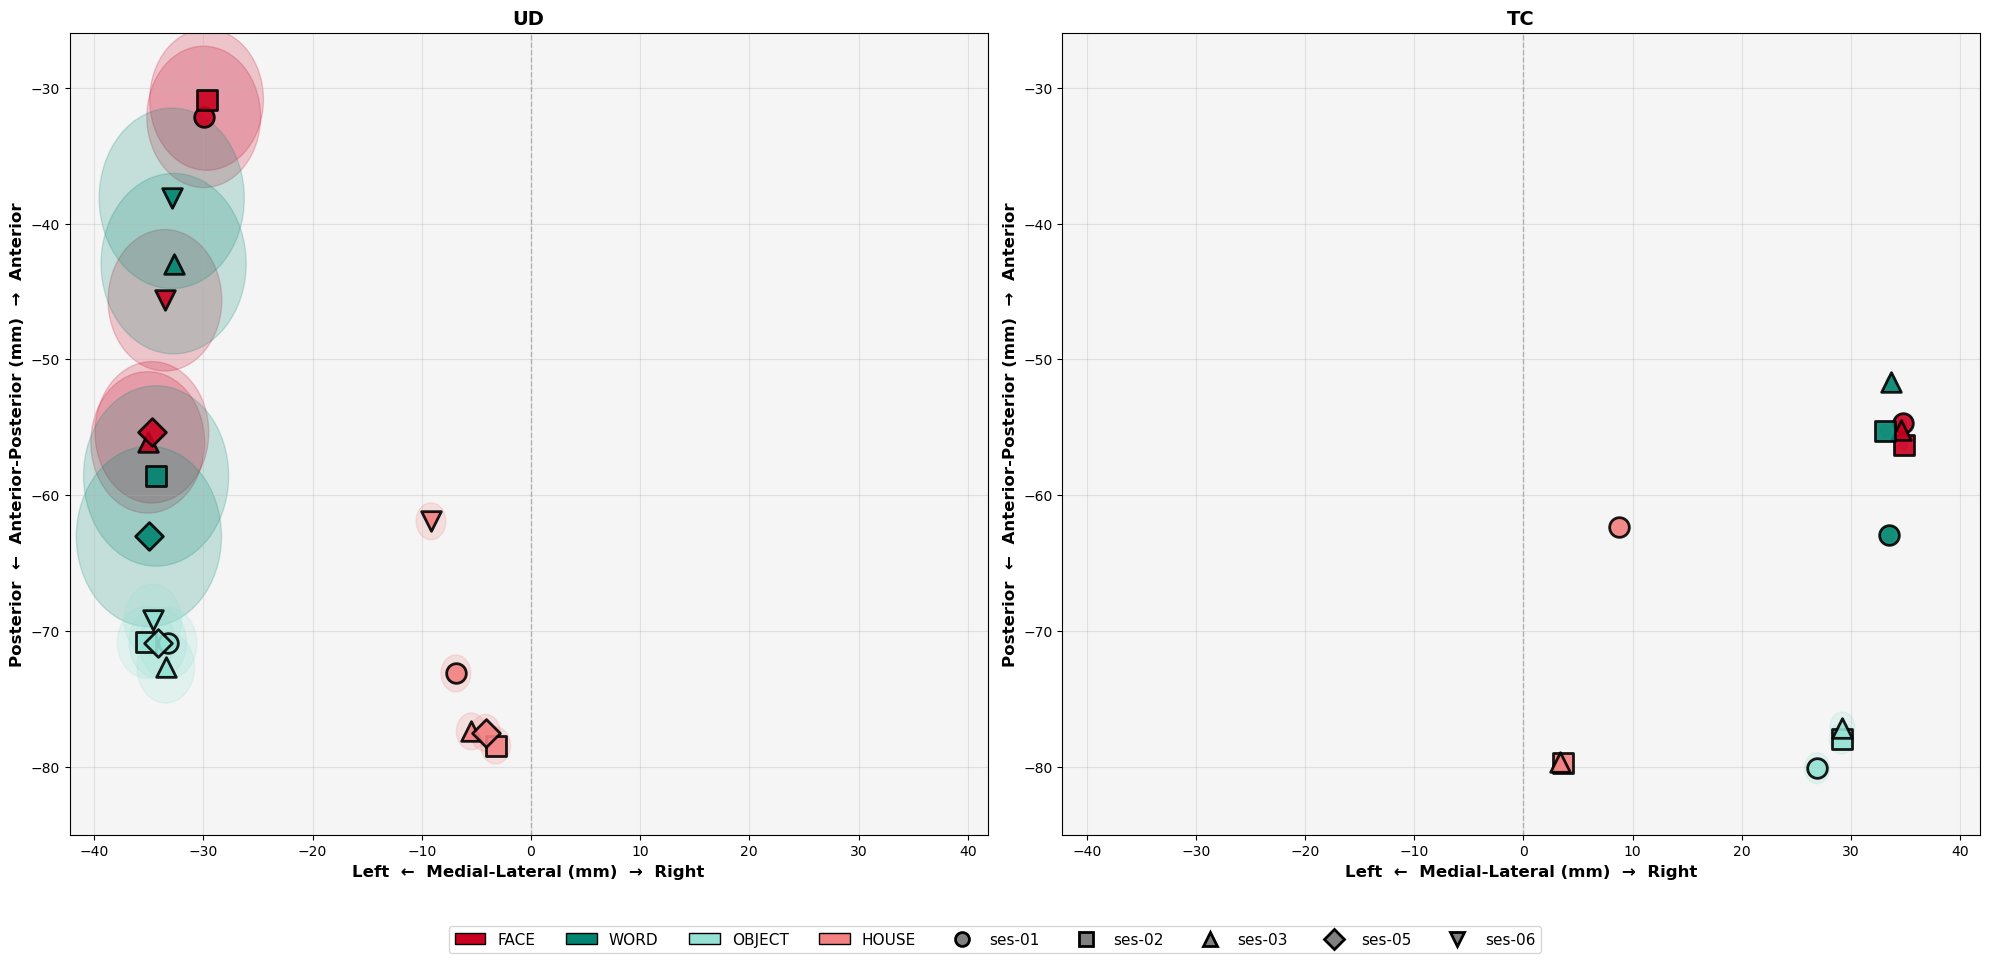

In [7]:
# CELL 4: Identify Peaks and Compute Bootstrapped Error Radii
def identify_runpair_peaks_baseline(subject_id, top_n_voxels=100):
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    
    print(f"\n{'='*70}")
    print(f"{code}: Identifying Peaks (top {top_n_voxels} voxel centroids)")
    print(f"{'='*70}")
    
    peak_coords = {}
    
    for category, cope_num in COPE_MAP.items():
        baseline_session = '01' if (subject_id == 'sub-004' and category == 'word') else '01' # update
        
        print(f"\n{category.upper()} (ses-{baseline_session}, cope {cope_num}):")
        
        parcel_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not parcel_file.exists():
            print(f"  No mask")
            continue
        
        parcel_mask = nib.load(parcel_file).get_fdata() > 0
        affine = nib.load(parcel_file).affine
        
        loc_dir = BASE_DIR / subject_id / f'ses-{baseline_session}' / 'derivatives' / 'fsl' / 'loc'
        run_dirs = sorted([d for d in loc_dir.glob('run-*') if d.is_dir()])
        
        if len(run_dirs) < 2:
            continue
        
        run_combos = [(r1, r2) for r1 in range(len(run_dirs)) for r2 in range(r1+1, len(run_dirs))]
        print(f"  {len(run_dirs)} runs → {len(run_combos)} pairs")
        
        pair_peaks = []
        
        for idx, (r1, r2) in enumerate(run_combos):
            zstat1_file = run_dirs[r1] / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{cope_num}.nii.gz'
            zstat2_file = run_dirs[r2] / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{cope_num}.nii.gz'
            
            if not (zstat1_file.exists() and zstat2_file.exists()):
                continue
            
            mean_zstat = (nib.load(zstat1_file).get_fdata() + nib.load(zstat2_file).get_fdata()) / 2
            masked_zstat = mean_zstat * parcel_mask
            
            flat_masked = masked_zstat.ravel()
            positive_indices = np.where(flat_masked > 0)[0]
            
            if len(positive_indices) < top_n_voxels:
                continue
            
            top_flat_indices = positive_indices[np.argsort(flat_masked[positive_indices])[-top_n_voxels:]]
            
            top_mask = np.zeros_like(masked_zstat, dtype=bool).ravel()
            top_mask[top_flat_indices] = True
            top_mask = top_mask.reshape(masked_zstat.shape)
            
            if top_mask.sum() == 0:
                continue
            
            peak_coord = nib.affines.apply_affine(affine, center_of_mass(top_mask))
            peak_z = np.max(mean_zstat[top_mask])
            
            pair_peaks.append({
                'index': idx,
                'run_pair': (r1, r2),
                'coord': peak_coord,
                'z_value': peak_z
            })
            
            print(f"    Pair {idx}: centroid={peak_coord}, z={peak_z:.2f}")
        
        if pair_peaks:
            peak_coords[category] = {
                'pair_peaks': pair_peaks,
                'baseline_session': baseline_session,
                'affine': affine,
                'brain_shape': parcel_mask.shape
            }
            print(f"  → {len(pair_peaks)} pairs")
    
    return peak_coords

def get_bootstrapped_error_radius(pair_peaks, n_bootstraps=100000):
    if not pair_peaks or len(pair_peaks) < 2:
        return 1.0
    
    data = np.array([p['coord'][:2] for p in pair_peaks])
    
    def stat_func(coords):
        if len(np.unique(coords[:, 0])) < 2 or len(np.unique(coords[:, 1])) < 2:
            return 0.0
        return np.sqrt(np.std(coords[:, 0])**2 + np.std(coords[:, 1])**2)
    
    bootstrapped_stats = [stat_func(data[np.random.choice(len(data), len(data), replace=True)]) 
                          for _ in range(n_bootstraps)]
    
    final_radius = np.mean(bootstrapped_stats)
    return final_radius if not np.isnan(final_radius) and final_radius > 0 else stat_func(data)

# Run analysis
print("="*70)
print("CORRECTED PEAK IDENTIFICATION")
print("="*70)

ud_peaks = identify_runpair_peaks_baseline('sub-004')
tc_peaks = identify_runpair_peaks_baseline('sub-021')

# Compute radii
print("\n" + "="*70)
print("BOOTSTRAPPED MEASUREMENT ERROR")
print("="*70)

radii = {}
for subject_id, peaks in [('sub-004', ud_peaks), ('sub-021', tc_peaks)]:
    code = SUBJECTS[subject_id]['code']
    radii[subject_id] = {}
    print(f"\n{code}:")
    for category, data in peaks.items():
        sd = get_bootstrapped_error_radius(data['pair_peaks'])
        radii[subject_id][category] = sd
        print(f"  {category}: {sd:.2f}mm")

print("\n✓ Complete!")


# CELL 2: Update Plot with Corrected Radii
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D

def plot_topography_with_measurement_error(functional_results, radii):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    colors = {'face': '#CA0020', 'word': '#018571', 'object': '#95E1D3', 'house': '#F38181'}
    markers = {'01': 'o', '02': 's', '03': '^', '05': 'D', '06': 'v'}
    
    all_x, all_y = [], []
    
    for ax, subject_id in zip([ax1, ax2], ['sub-004', 'sub-021']):
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        for category in ['face', 'word', 'object', 'house']:
            if category not in functional_results[subject_id]:
                continue
            
            error_radius = radii[subject_id].get(category, 1.0)
            
            for session in sessions:
                if session not in functional_results[subject_id][category]:
                    continue
                
                centroid = functional_results[subject_id][category][session]['centroid']
                x, y = centroid[0], centroid[1]
                
                all_x.append(x)
                all_y.append(y)
                
                ax.add_patch(Circle((x, y), error_radius, color=colors[category], alpha=0.2, zorder=1))
                ax.scatter(x, y, c=colors[category], marker=markers.get(session, 'o'),
                          s=200, edgecolors='black', linewidth=2, alpha=0.9, zorder=3)
        
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('Left  ←  Medial-Lateral (mm)  →  Right', fontsize=12, fontweight='bold')
        ax.set_ylabel('Posterior  ←  Anterior-Posterior (mm)  →  Anterior', fontsize=12, fontweight='bold')
        ax.set_title(f'{code}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#F5F5F5')
    
    x_margin = (max(all_x) - min(all_x)) * 0.1
    y_margin = (max(all_y) - min(all_y)) * 0.1
    
    xlim = [min(all_x) - x_margin, max(all_x) + x_margin]
    ylim = [min(all_y) - y_margin, max(all_y) + y_margin]
    
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    
    category_legend = [Patch(facecolor=colors[cat], edgecolor='black', label=cat.upper()) 
                      for cat in ['face', 'word', 'object', 'house']]
    session_legend = [Line2D([0], [0], marker=markers.get(s, 'o'), color='w', 
                            markerfacecolor='gray', markersize=10, 
                            markeredgecolor='black', markeredgewidth=2, label=f'ses-{s}')
                     for s in ['01', '02', '03', '05', '06']]
    
    fig.legend(handles=category_legend + session_legend, 
              loc='center', bbox_to_anchor=(0.5, -0.05), 
              ncol=9, fontsize=11, frameon=True)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'topography_corrected_copes.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot with corrected radii
plot_topography_with_measurement_error(golarai_functional_final, radii)

CALCULATING CENTROID DRIFT

UD: Centroid Drift Analysis

FACE (measurement error: 5.21mm):
  Baseline (ses-01): [-29.97619048 -32.14285714  -3.01904762]
  ses-02: [-29.7115903  -30.86792453  -4.18598383]
    → Drift from baseline: 1.75mm (0.34× error)
  ses-03: [-35.10559796 -56.11959288  -5.42239186]
    → Drift from baseline: 24.64mm (4.73× error)
    → Drift from ses-02: 25.85mm (4.96× error)
  ses-05: [-34.72152886 -55.37597504  -6.0124805 ]
    → Drift from baseline: 23.90mm (4.59× error)
    → Drift from ses-03: 1.02mm (0.20× error)
  ses-06: [-33.52702703 -45.65124028  -4.74416883]
    → Drift from baseline: 14.07mm (2.70× error)
    → Drift from ses-05: 9.88mm (1.90× error)

WORD (measurement error: 6.65mm):
  Baseline (ses-02): [-34.33625337 -58.58962264  -1.41644205]
  ses-03: [-32.72939217 -42.95253955  -2.96086595]
    → Drift from baseline: 15.80mm (2.38× error)
  ses-05: [-34.99408284 -63.04832347  -3.59861933]
    → Drift from baseline: 5.01mm (0.75× error)
    → Drift f

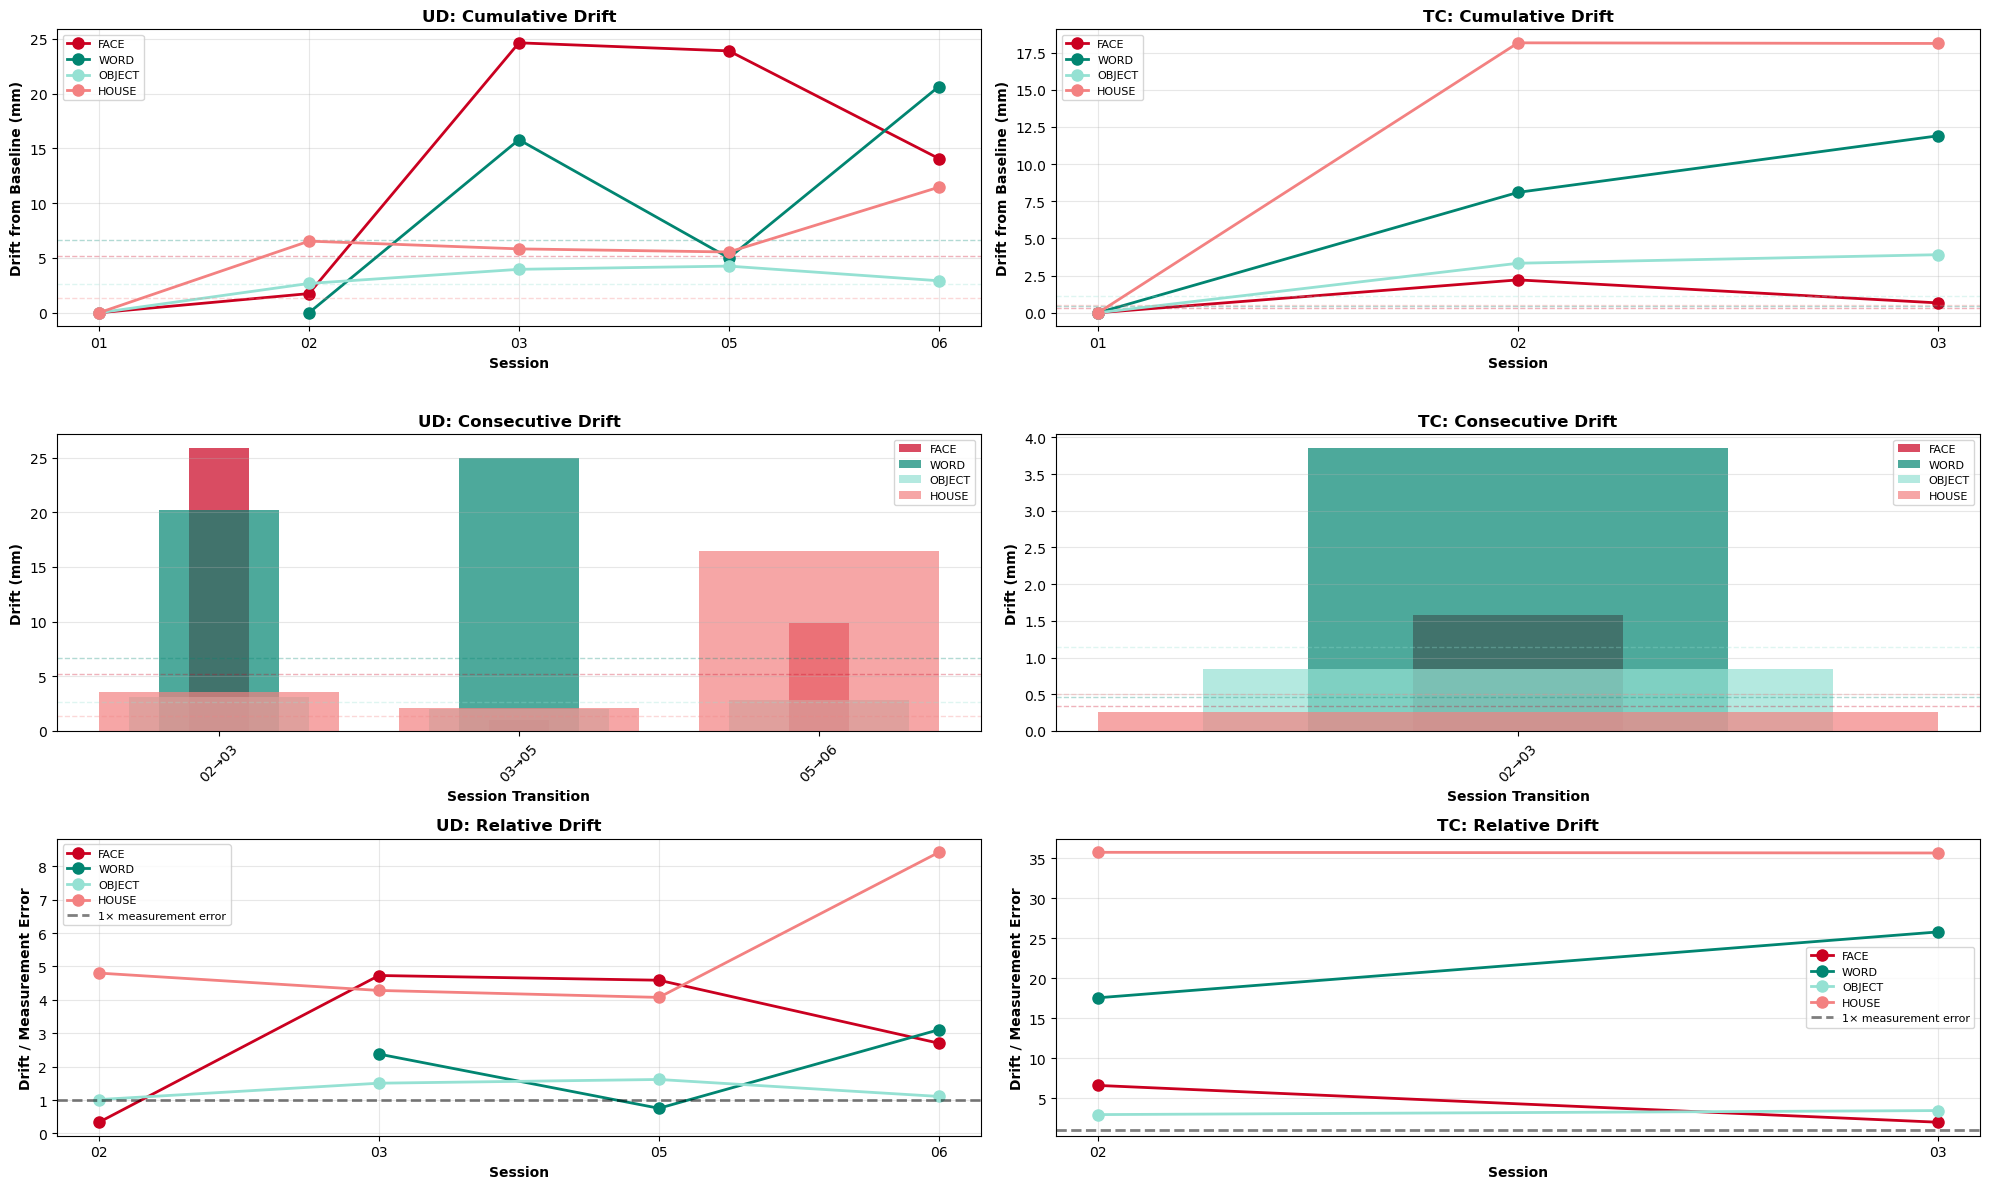


DRIFT SUMMARY TABLE

UD:
Category   Max Drift (mm)  Mean Drift (mm) Relative to Error   
----------------------------------------------------------------------
face       24.64           16.09           4.73                ×
word       20.65           13.82           3.11                ×
object     4.26            3.45            1.62                ×
house      11.46           7.34            8.42                ×

TC:
Category   Max Drift (mm)  Mean Drift (mm) Relative to Error   
----------------------------------------------------------------------
face       2.21            1.44            6.58                ×
word       11.90           10.00           25.80               ×
object     3.91            3.62            3.43                ×
house      18.16           18.14           35.77               ×

✓ Drift analysis complete!


In [8]:
# CELL 5: Quantify Centroid Drift Across Sessions

def calculate_centroid_drift(functional_results, radii):
    """
    Calculate drift between sessions for each category.
    Returns both consecutive session drift and drift from baseline.
    """
    drift_results = {}
    
    for subject_id, categories in functional_results.items():
        code = SUBJECTS[subject_id]['code']
        drift_results[subject_id] = {}
        
        print(f"\n{'='*70}")
        print(f"{code}: Centroid Drift Analysis")
        print(f"{'='*70}")
        
        for category, sessions_data in categories.items():
            if len(sessions_data) < 2:
                continue
            
            sessions = sorted(sessions_data.keys())
            baseline_session = sessions[0]
            baseline_centroid = sessions_data[baseline_session]['centroid']
            error_radius = radii[subject_id].get(category, 1.0)
            
            print(f"\n{category.upper()} (measurement error: {error_radius:.2f}mm):")
            print(f"  Baseline (ses-{baseline_session}): {baseline_centroid}")
            
            # Store drift data
            drift_results[subject_id][category] = {
                'baseline_session': baseline_session,
                'baseline_centroid': baseline_centroid,
                'error_radius': error_radius,
                'consecutive_drift': [],
                'from_baseline_drift': [],
                'sessions': sessions
            }
            
            # Calculate drift from baseline
            for i, session in enumerate(sessions[1:], 1):
                current_centroid = sessions_data[session]['centroid']
                
                # Drift from baseline
                drift_from_baseline = np.linalg.norm(current_centroid - baseline_centroid)
                drift_results[subject_id][category]['from_baseline_drift'].append({
                    'session': session,
                    'distance_mm': drift_from_baseline,
                    'relative_to_error': drift_from_baseline / error_radius
                })
                
                print(f"  ses-{session}: {current_centroid}")
                print(f"    → Drift from baseline: {drift_from_baseline:.2f}mm ({drift_from_baseline/error_radius:.2f}× error)")
                
                # Drift from previous session
                if i > 1:
                    prev_session = sessions[i-1]
                    prev_centroid = sessions_data[prev_session]['centroid']
                    consecutive_drift = np.linalg.norm(current_centroid - prev_centroid)
                    
                    drift_results[subject_id][category]['consecutive_drift'].append({
                        'from_session': prev_session,
                        'to_session': session,
                        'distance_mm': consecutive_drift,
                        'relative_to_error': consecutive_drift / error_radius
                    })
                    
                    print(f"    → Drift from ses-{prev_session}: {consecutive_drift:.2f}mm ({consecutive_drift/error_radius:.2f}× error)")
    
    return drift_results

def plot_drift_analysis(drift_results, functional_results):
    """
    Visualize centroid drift over time.
    """
    fig = plt.figure(figsize=(20, 12))
    
    colors = {'face': '#CA0020', 'word': '#018571', 'object': '#95E1D3', 'house': '#F38181'}
    
    # Create subplot grid
    n_subjects = len(drift_results)
    
    for subj_idx, (subject_id, categories) in enumerate(drift_results.items()):
        code = SUBJECTS[subject_id]['code']
        
        # Plot 1: Drift from baseline over time
        ax1 = plt.subplot(3, n_subjects, subj_idx + 1)
        for category, data in categories.items():
            if not data['from_baseline_drift']:
                continue
            
            sessions = [data['baseline_session']] + [d['session'] for d in data['from_baseline_drift']]
            distances = [0] + [d['distance_mm'] for d in data['from_baseline_drift']]
            
            ax1.plot(sessions, distances, 'o-', color=colors[category], 
                    linewidth=2, markersize=8, label=category.upper())
            
            # Add error radius as horizontal reference line
            ax1.axhline(y=data['error_radius'], color=colors[category], 
                       linestyle='--', alpha=0.3, linewidth=1)
        
        ax1.set_xlabel('Session', fontweight='bold')
        ax1.set_ylabel('Drift from Baseline (mm)', fontweight='bold')
        ax1.set_title(f'{code}: Cumulative Drift', fontweight='bold')
        ax1.legend(loc='best', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Consecutive session drift
        ax2 = plt.subplot(3, n_subjects, n_subjects + subj_idx + 1)
        for category, data in categories.items():
            if not data['consecutive_drift']:
                continue
            
            transitions = [f"{d['from_session']}→{d['to_session']}" for d in data['consecutive_drift']]
            distances = [d['distance_mm'] for d in data['consecutive_drift']]
            
            x_pos = np.arange(len(transitions))
            ax2.bar(x_pos, distances, color=colors[category], alpha=0.7, 
                   label=category.upper(), width=0.2 * (list(categories.keys()).index(category) + 1))
            
            # Add error radius reference
            ax2.axhline(y=data['error_radius'], color=colors[category], 
                       linestyle='--', alpha=0.3, linewidth=1)
        
        ax2.set_xlabel('Session Transition', fontweight='bold')
        ax2.set_ylabel('Drift (mm)', fontweight='bold')
        ax2.set_title(f'{code}: Consecutive Drift', fontweight='bold')
        if transitions:
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels(transitions, rotation=45)
        ax2.legend(loc='best', fontsize=8)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Plot 3: Drift relative to measurement error
        ax3 = plt.subplot(3, n_subjects, 2*n_subjects + subj_idx + 1)
        for category, data in categories.items():
            if not data['from_baseline_drift']:
                continue
            
            sessions = [d['session'] for d in data['from_baseline_drift']]
            relative_drift = [d['relative_to_error'] for d in data['from_baseline_drift']]
            
            ax3.plot(sessions, relative_drift, 'o-', color=colors[category], 
                    linewidth=2, markersize=8, label=category.upper())
        
        ax3.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, linewidth=2, 
                   label='1× measurement error')
        ax3.set_xlabel('Session', fontweight='bold')
        ax3.set_ylabel('Drift / Measurement Error', fontweight='bold')
        ax3.set_title(f'{code}: Relative Drift', fontweight='bold')
        ax3.legend(loc='best', fontsize=8)
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'centroid_drift_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_drift_summary_table(drift_results):
    """
    Create summary statistics table for drift.
    """
    print("\n" + "="*70)
    print("DRIFT SUMMARY TABLE")
    print("="*70)
    
    for subject_id, categories in drift_results.items():
        code = SUBJECTS[subject_id]['code']
        print(f"\n{code}:")
        print(f"{'Category':<10} {'Max Drift (mm)':<15} {'Mean Drift (mm)':<15} {'Relative to Error':<20}")
        print("-" * 70)
        
        for category, data in categories.items():
            if not data['from_baseline_drift']:
                continue
            
            distances = [d['distance_mm'] for d in data['from_baseline_drift']]
            max_drift = max(distances)
            mean_drift = np.mean(distances)
            max_relative = max_drift / data['error_radius']
            
            print(f"{category:<10} {max_drift:<15.2f} {mean_drift:<15.2f} {max_relative:<20.2f}×")

# Run drift analysis
print("="*70)
print("CALCULATING CENTROID DRIFT")
print("="*70)

drift_data = calculate_centroid_drift(golarai_functional_final, radii)
plot_drift_analysis(drift_data, golarai_functional_final)
create_drift_summary_table(drift_data)

print("\n✓ Drift analysis complete!")

EXTRACTING FROM 6MM SPHERES


UD - face: 898 voxels (baseline: ses-01) at [-30.0, -32.1, -3.0]
UD - word: 908 voxels (baseline: ses-02) at [-34.3, -58.6, -1.4]
UD - object: 902 voxels (baseline: ses-01) at [-33.2, -70.9, 10.9]
UD - house: 904 voxels (baseline: ses-01) at [-6.9, -73.1, 8.3]


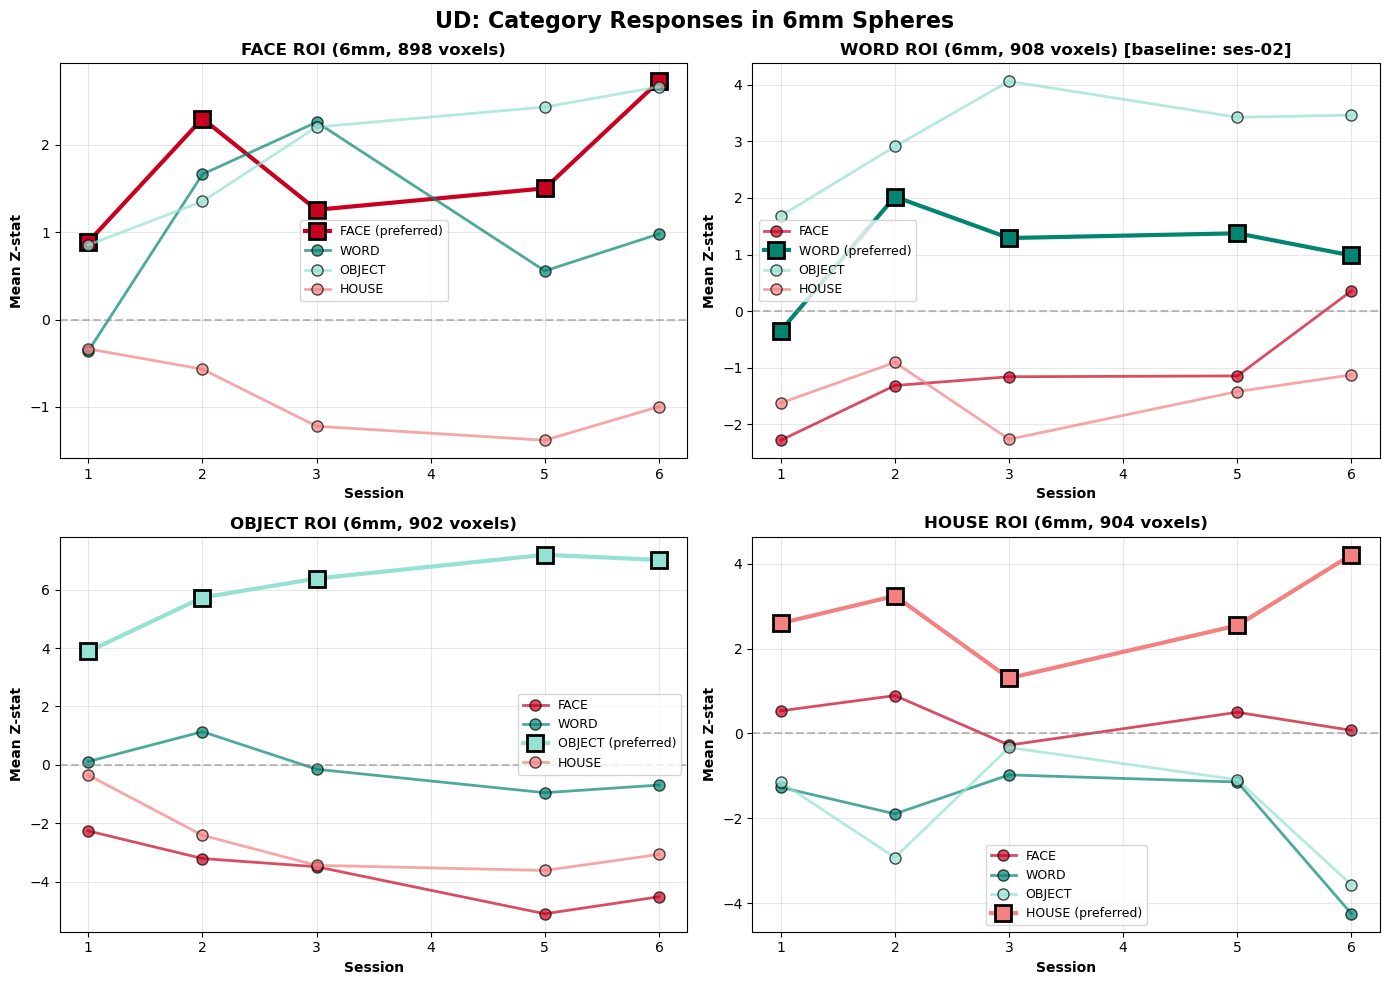

TC - face: 912 voxels (baseline: ses-01) at [34.8, -54.7, -0.3]
TC - word: 895 voxels (baseline: ses-01) at [33.5, -62.9, 5.5]
TC - object: 906 voxels (baseline: ses-01) at [26.9, -80.1, 13.3]
TC - house: 912 voxels (baseline: ses-01) at [8.8, -62.3, 14.3]


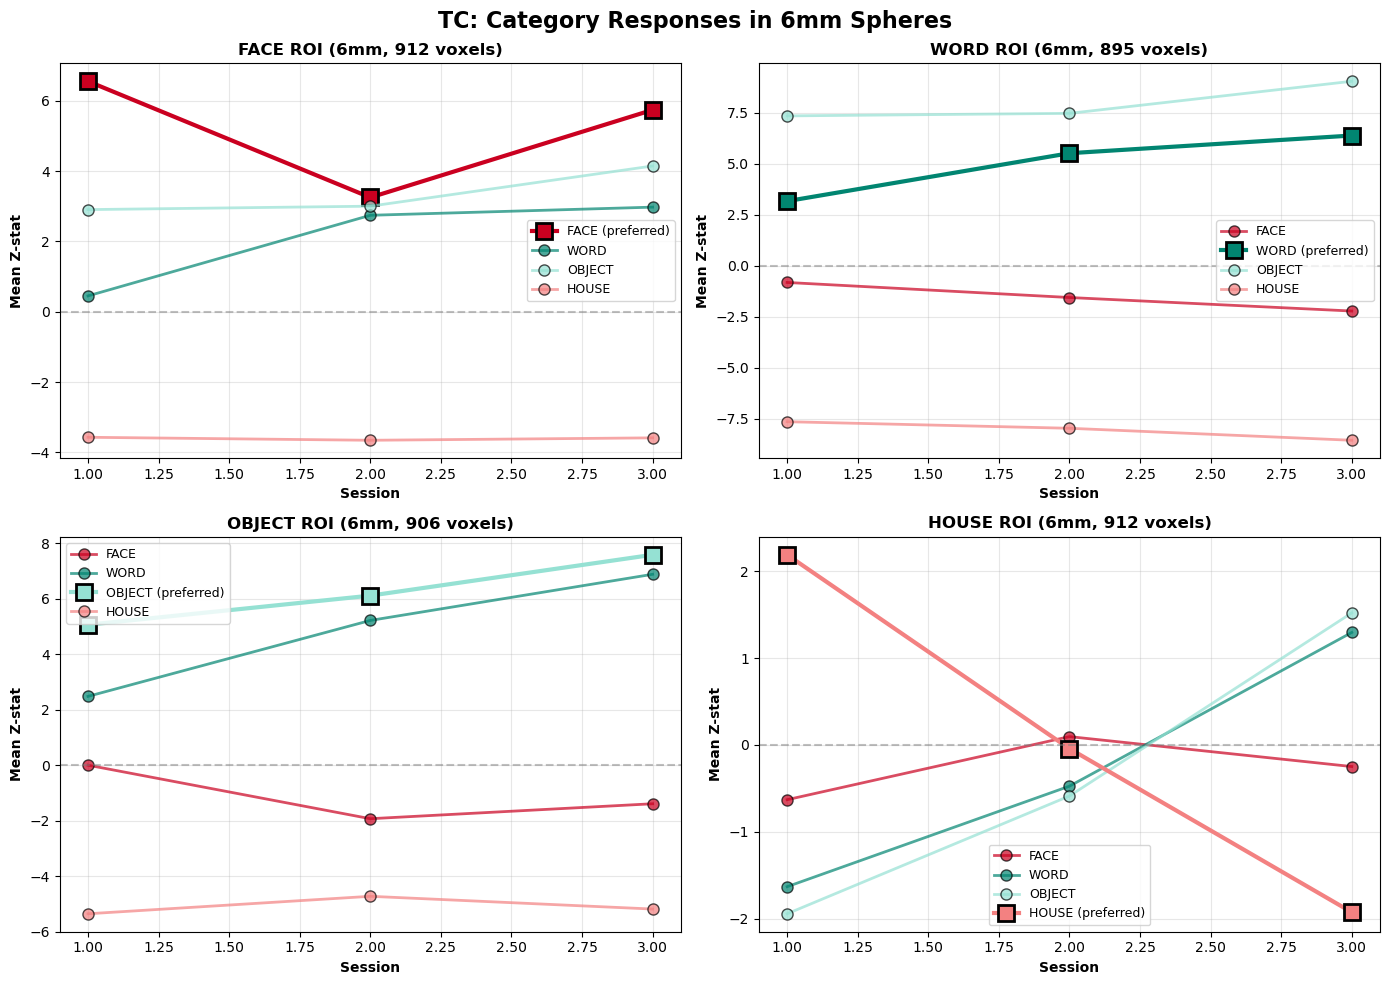


✓ Done!


In [20]:
# SIMPLE VERSION: 6mm spheres from saved coordinates (FIXED for UD word baseline)

def create_6mm_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create a single 6mm sphere around a peak."""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), 
        np.arange(brain_shape[1]), 
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d


def extract_and_plot_simple(functional_results):
    """
    Extract mean z-stats from 6mm spheres and plot.
    """
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    colors = {'face': '#CA0020', 'word': '#018571', 'object': '#95E1D3', 'house': '#F38181'}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = SUBJECTS[subject_id]['hemi']
        sessions = SUBJECTS[subject_id]['sessions']
        
        # Get reference for affine
        ref_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        # Create figure with subplots for each ROI
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        roi_idx = 0
        for roi_name in ['face', 'word', 'object', 'house']:
            ax = axes[roi_idx]
            
            # Determine baseline session (special case for UD word)
            if subject_id == 'sub-004' and roi_name == 'word':
                baseline_session = '02'
            else:
                baseline_session = '01'
            
            # Check if we have baseline data
            if roi_name not in functional_results[subject_id]:
                ax.text(0.5, 0.5, f'No {roi_name} ROI', ha='center', va='center')
                ax.set_title(f'{roi_name.upper()}')
                ax.set_xlim([0, 10])
                ax.set_ylim([0, 1])
                roi_idx += 1
                continue
            
            if baseline_session not in functional_results[subject_id][roi_name]:
                ax.text(0.5, 0.5, f'No ses-{baseline_session} baseline', ha='center', va='center')
                ax.set_title(f'{roi_name.upper()}')
                ax.set_xlim([0, 10])
                ax.set_ylim([0, 1])
                roi_idx += 1
                continue
            
            # Get peak coordinate from baseline session
            peak = functional_results[subject_id][roi_name][baseline_session]['centroid']
            
            # Create 6mm sphere
            sphere_mask = create_6mm_sphere(peak, affine, brain_shape, radius=6)
            n_voxels = sphere_mask.sum()
            
            print(f"{code} - {roi_name}: {n_voxels} voxels (baseline: ses-{baseline_session}) at [{peak[0]:.1f}, {peak[1]:.1f}, {peak[2]:.1f}]")
            
            # Extract z-stats for all categories across sessions
            for category, cope_num in category_copes.items():
                zstats = []
                session_nums = []
                
                for session in sessions:
                    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                    
                    if session == '01':
                        zfile = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
                    else:
                        zfile = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
                    
                    if zfile.exists():
                        zdata = nib.load(zfile).get_fdata()
                        roi_vals = zdata[sphere_mask]
                        mean_z = np.mean(roi_vals[np.isfinite(roi_vals)])
                        zstats.append(mean_z)
                        session_nums.append(int(session))
                
                # Plot
                if category == roi_name:
                    ax.plot(session_nums, zstats, 's-', color=colors[category], 
                           linewidth=3, markersize=12, label=f'{category.upper()} (preferred)',
                           markeredgecolor='black', markeredgewidth=2)
                else:
                    ax.plot(session_nums, zstats, 'o-', color=colors[category], 
                           linewidth=2, markersize=8, label=category.upper(),
                           markeredgecolor='black', markeredgewidth=1, alpha=0.7)
            
            ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Session', fontweight='bold')
            ax.set_ylabel('Mean Z-stat', fontweight='bold')
            
            title = f'{roi_name.upper()} ROI (6mm, {n_voxels} voxels)'
            if baseline_session != '01':
                title += f' [baseline: ses-{baseline_session}]'
            ax.set_title(title, fontweight='bold')
            ax.legend(loc='best', fontsize=9)
            
            roi_idx += 1
        
        fig.suptitle(f'{code}: Category Responses in 6mm Spheres', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f'{code}_selectivity_6mm_simple.png', dpi=300, bbox_inches='tight')
        plt.show()


# RUN IT
print("="*70)
print("EXTRACTING FROM 6MM SPHERES")
print("="*70)

extract_and_plot_simple(golarai_functional_final)

print("\n✓ Done!")

EXTRACTING PREFERRED CATEGORY FROM 6MM SPHERES
UD - face: 898 voxels (baseline: ses-01) at [-30.0, -32.1, -3.0]
  ses-01: 0.89
  ses-02: 2.30
  ses-03: 1.26
  ses-05: 1.50
  ses-06: 2.73
UD - word: 908 voxels (baseline: ses-02) at [-34.3, -58.6, -1.4]
  ses-01: -0.34
  ses-02: 2.02
  ses-03: 1.29
  ses-05: 1.38
  ses-06: 0.98
UD - object: 902 voxels (baseline: ses-01) at [-33.2, -70.9, 10.9]
  ses-01: 3.88
  ses-02: 5.73
  ses-03: 6.38
  ses-05: 7.19
  ses-06: 7.02
UD - house: 904 voxels (baseline: ses-01) at [-6.9, -73.1, 8.3]
  ses-01: 2.60
  ses-02: 3.24
  ses-03: 1.30
  ses-05: 2.55
  ses-06: 4.21


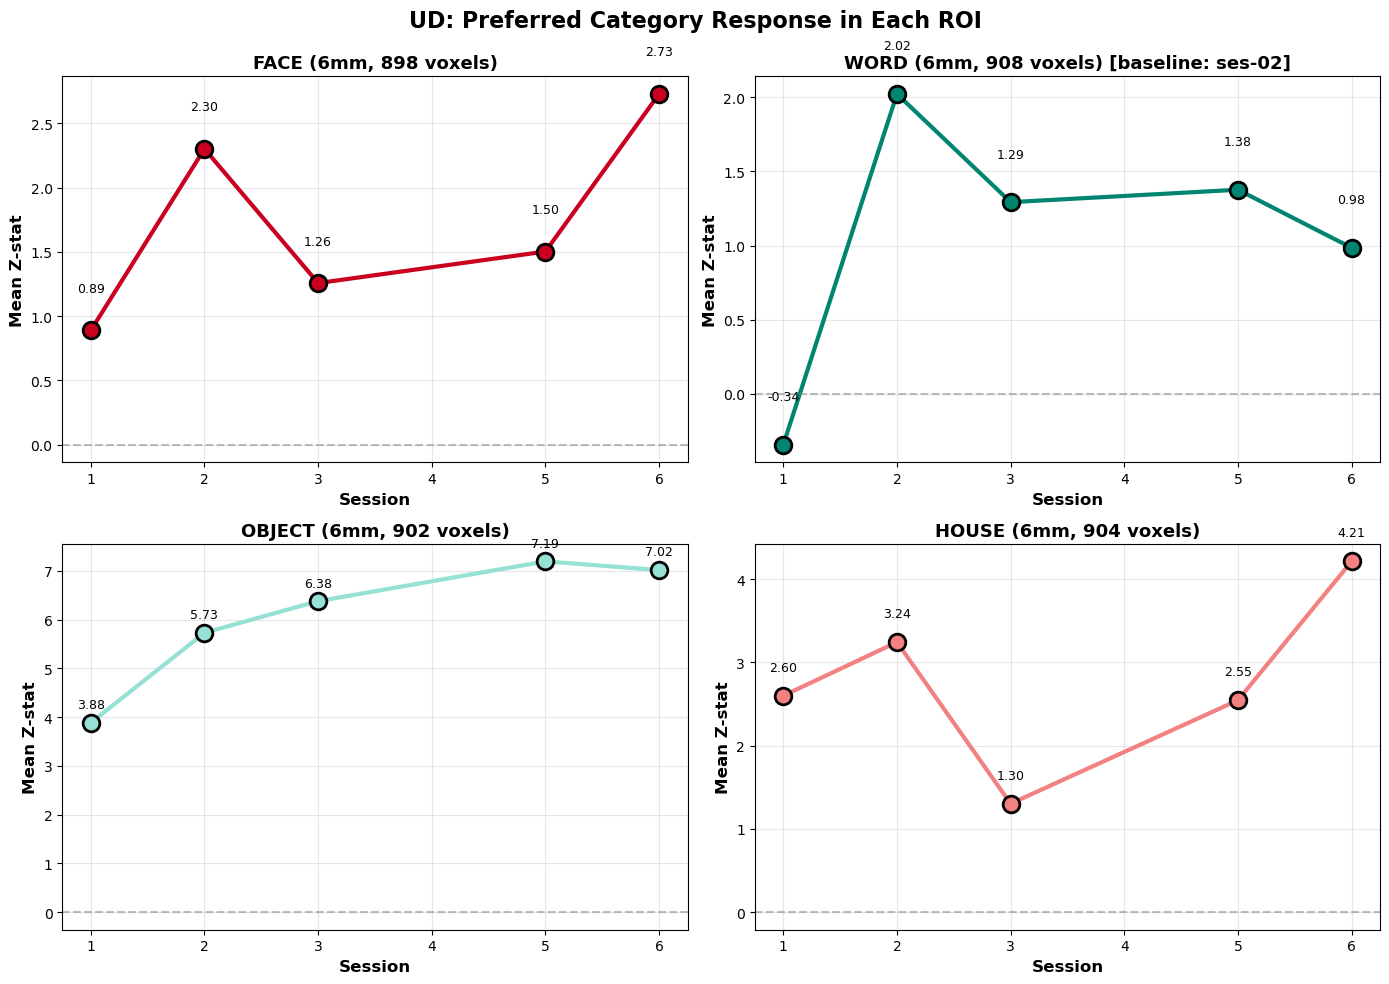

TC - face: 912 voxels (baseline: ses-01) at [34.8, -54.7, -0.3]
  ses-01: 6.55
  ses-02: 3.25
  ses-03: 5.74
TC - word: 895 voxels (baseline: ses-01) at [33.5, -62.9, 5.5]
  ses-01: 3.16
  ses-02: 5.51
  ses-03: 6.38
TC - object: 906 voxels (baseline: ses-01) at [26.9, -80.1, 13.3]
  ses-01: 5.06
  ses-02: 6.10
  ses-03: 7.58
TC - house: 912 voxels (baseline: ses-01) at [8.8, -62.3, 14.3]
  ses-01: 2.19
  ses-02: -0.04
  ses-03: -1.92


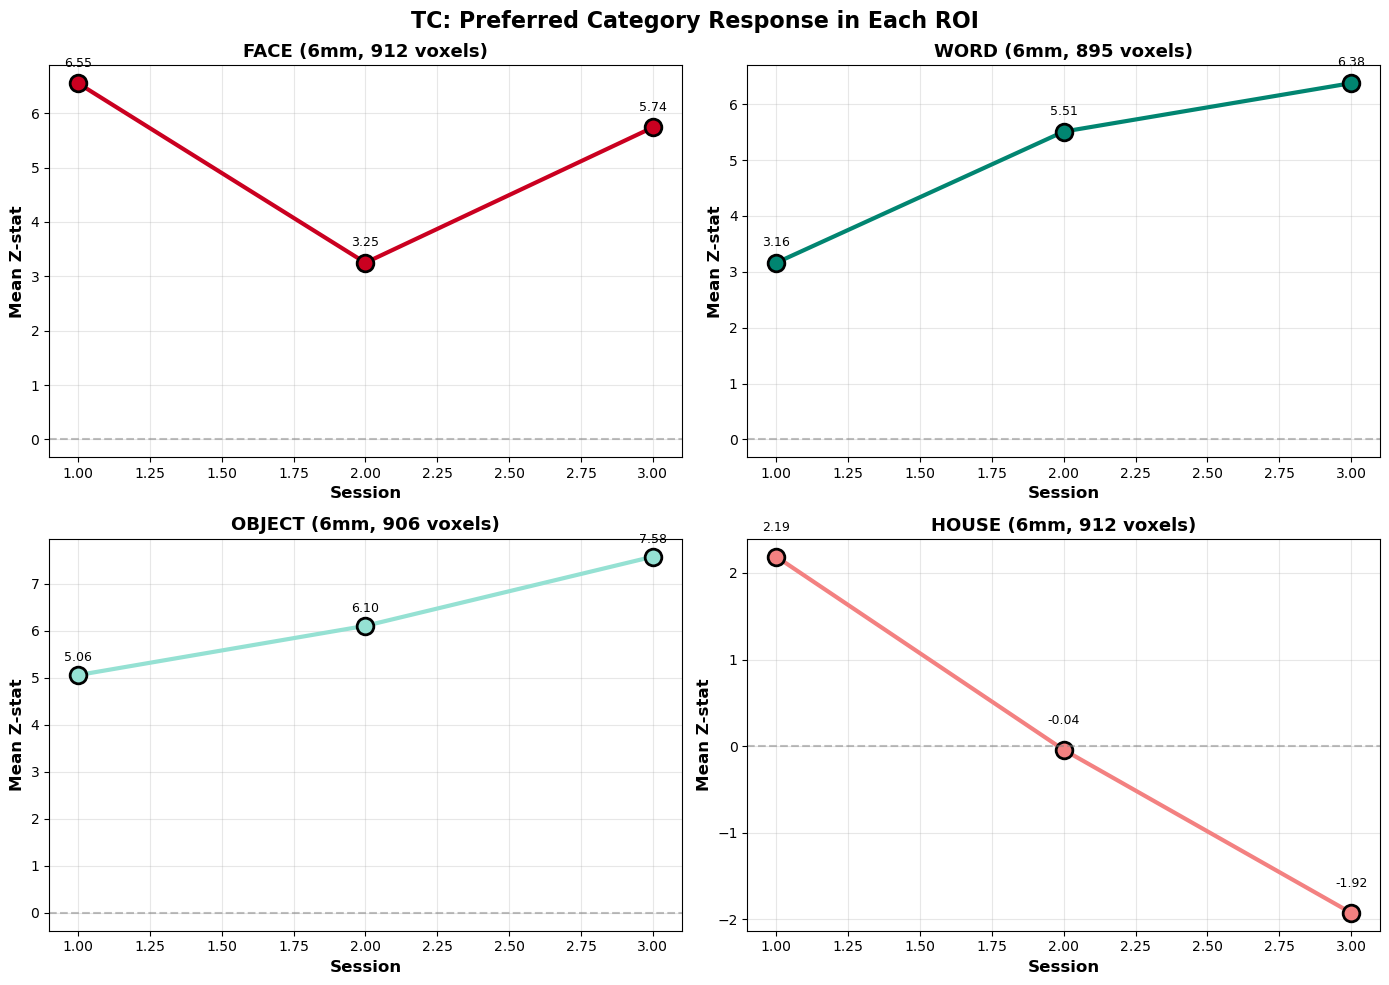


✓ Done!


In [18]:
# OPTION B: Plot only preferred category in each ROI (FIXED for word baseline)

def extract_and_plot_preferred_only(functional_results):
    """
    Extract mean z-stats from 6mm spheres - only preferred category per ROI.
    Handles special case: UD word ROI uses session 02 as baseline.
    """
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    colors = {'face': '#CA0020', 'word': '#018571', 'object': '#95E1D3', 'house': '#F38181'}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = SUBJECTS[subject_id]['hemi']
        sessions = SUBJECTS[subject_id]['sessions']
        
        # Get reference for affine
        ref_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        # Create figure with subplots for each ROI
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        roi_idx = 0
        for roi_name in ['face', 'word', 'object', 'house']:
            ax = axes[roi_idx]
            
            # Determine baseline session (special case for UD word)
            if subject_id == 'sub-004' and roi_name == 'word':
                baseline_session = '02'
            else:
                baseline_session = '01'
            
            # Check if we have baseline data
            if roi_name not in functional_results[subject_id]:
                ax.text(0.5, 0.5, f'No {roi_name} ROI', ha='center', va='center', fontsize=12)
                ax.set_title(f'{roi_name.upper()}', fontweight='bold')
                ax.set_xlim([0, 10])
                ax.set_ylim([0, 1])
                roi_idx += 1
                continue
            
            if baseline_session not in functional_results[subject_id][roi_name]:
                ax.text(0.5, 0.5, f'No ses-{baseline_session} baseline', ha='center', va='center', fontsize=12)
                ax.set_title(f'{roi_name.upper()}', fontweight='bold')
                ax.set_xlim([0, 10])
                ax.set_ylim([0, 1])
                roi_idx += 1
                continue
            
            # Get peak coordinate from baseline session
            peak = functional_results[subject_id][roi_name][baseline_session]['centroid']
            
            # Create 6mm sphere
            grid_coords = np.array(np.meshgrid(
                np.arange(brain_shape[0]), 
                np.arange(brain_shape[1]), 
                np.arange(brain_shape[2]),
                indexing='ij'
            )).reshape(3, -1).T
            
            grid_world = nib.affines.apply_affine(affine, grid_coords)
            distances = np.linalg.norm(grid_world - peak, axis=1)
            
            sphere_mask = np.zeros(brain_shape, dtype=bool)
            within = grid_coords[distances <= 6]
            for coord in within:
                sphere_mask[coord[0], coord[1], coord[2]] = True
            
            n_voxels = sphere_mask.sum()
            
            print(f"{code} - {roi_name}: {n_voxels} voxels (baseline: ses-{baseline_session}) at [{peak[0]:.1f}, {peak[1]:.1f}, {peak[2]:.1f}]")
            
            # Extract z-stats for ONLY the preferred category
            cope_num = category_copes[roi_name]
            zstats = []
            session_nums = []
            
            for session in sessions:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                if session == '01':
                    zfile = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
                else:
                    zfile = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
                
                if zfile.exists():
                    zdata = nib.load(zfile).get_fdata()
                    roi_vals = zdata[sphere_mask]
                    mean_z = np.mean(roi_vals[np.isfinite(roi_vals)])
                    zstats.append(mean_z)
                    session_nums.append(int(session))
                    print(f"  ses-{session}: {mean_z:.2f}")
            
            # Plot
            ax.plot(session_nums, zstats, 'o-', color=colors[roi_name], 
                   linewidth=3, markersize=12, 
                   markeredgecolor='black', markeredgewidth=2)
            
            # Add value labels
            for x, y in zip(session_nums, zstats):
                ax.text(x, y + 0.3, f'{y:.2f}', ha='center', fontsize=9)
            
            ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Session', fontweight='bold', fontsize=12)
            ax.set_ylabel('Mean Z-stat', fontweight='bold', fontsize=12)
            
            title = f'{roi_name.upper()} (6mm, {n_voxels} voxels)'
            if baseline_session != '01':
                title += f' [baseline: ses-{baseline_session}]'
            ax.set_title(title, fontweight='bold', fontsize=13)
            
            roi_idx += 1
        
        fig.suptitle(f'{code}: Preferred Category Response in Each ROI', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f'{code}_selectivity_6mm_preferred_only.png', dpi=300, bbox_inches='tight')
        plt.show()


# RUN IT
print("="*70)
print("EXTRACTING PREFERRED CATEGORY FROM 6MM SPHERES")
print("="*70)

extract_and_plot_preferred_only(golarai_functional_final)

print("\n✓ Done!")

COMPUTING SELECTIVITY MEASURES

UD - FACE (898 voxels, baseline: ses-01)
  ses-01: mean_z=0.89, selectivity=0.887, contrast=0.84, sum=917.4
  ses-02: mean_z=2.30, selectivity=0.476, contrast=1.49, sum=2101.5
  ses-03: mean_z=1.26, selectivity=0.075, contrast=0.18, sum=1176.5
  ses-05: mean_z=1.50, selectivity=0.474, contrast=0.97, sum=1575.0
  ses-06: mean_z=2.73, selectivity=0.511, contrast=1.85, sum=2521.4

UD - WORD (908 voxels, baseline: ses-02)
  ses-01: mean_z=-0.34, selectivity=-0.365, contrast=0.39, sum=281.4
  ses-02: mean_z=2.02, selectivity=0.794, contrast=1.79, sum=1979.2
  ses-03: mean_z=1.29, selectivity=0.716, contrast=1.08, sum=1365.7
  ses-05: mean_z=1.38, selectivity=0.654, contrast=1.09, sum=1565.4
  ses-06: mean_z=0.98, selectivity=0.045, contrast=0.09, sum=1043.4

UD - OBJECT (902 voxels, baseline: ses-01)
  ses-01: mean_z=3.88, selectivity=1.547, contrast=4.72, sum=3503.8
  ses-02: mean_z=5.73, selectivity=1.706, contrast=7.23, sum=5169.4
  ses-03: mean_z=6.38, se

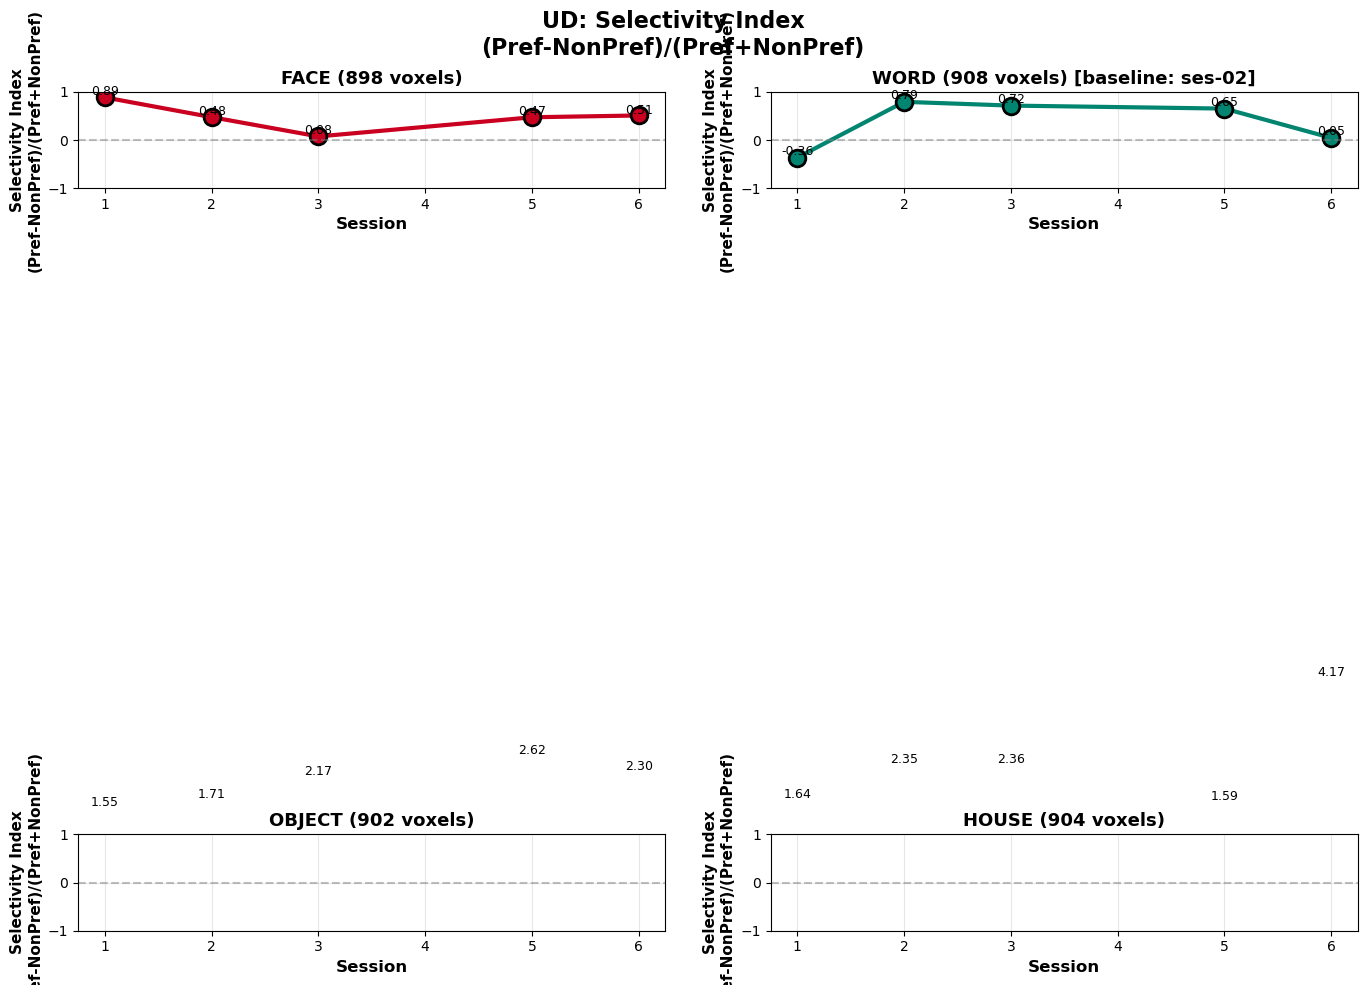

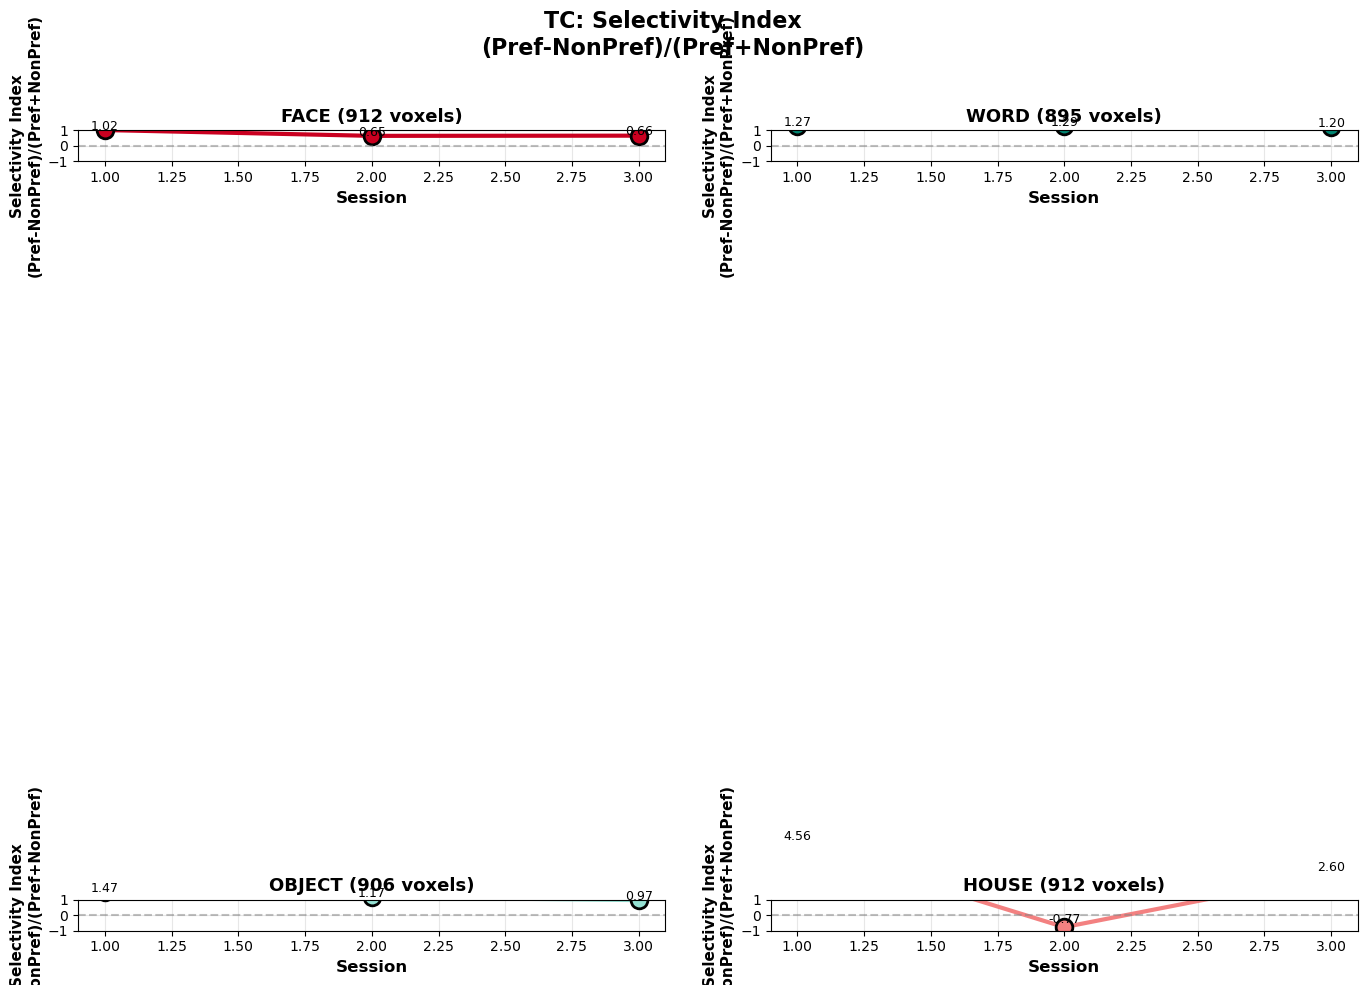


PLOTTING CONTRAST


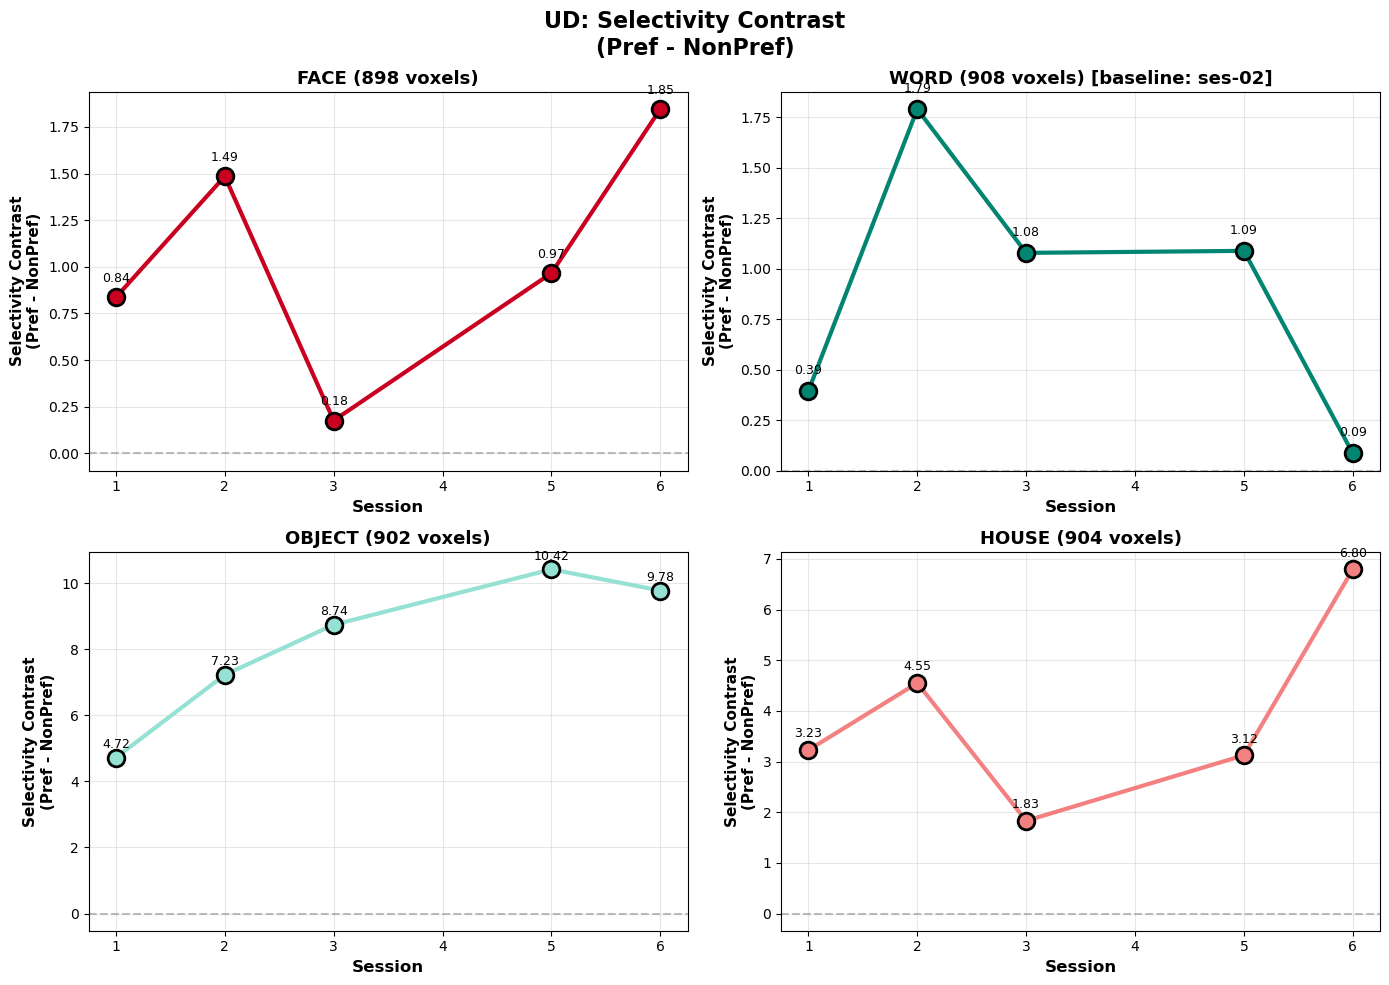

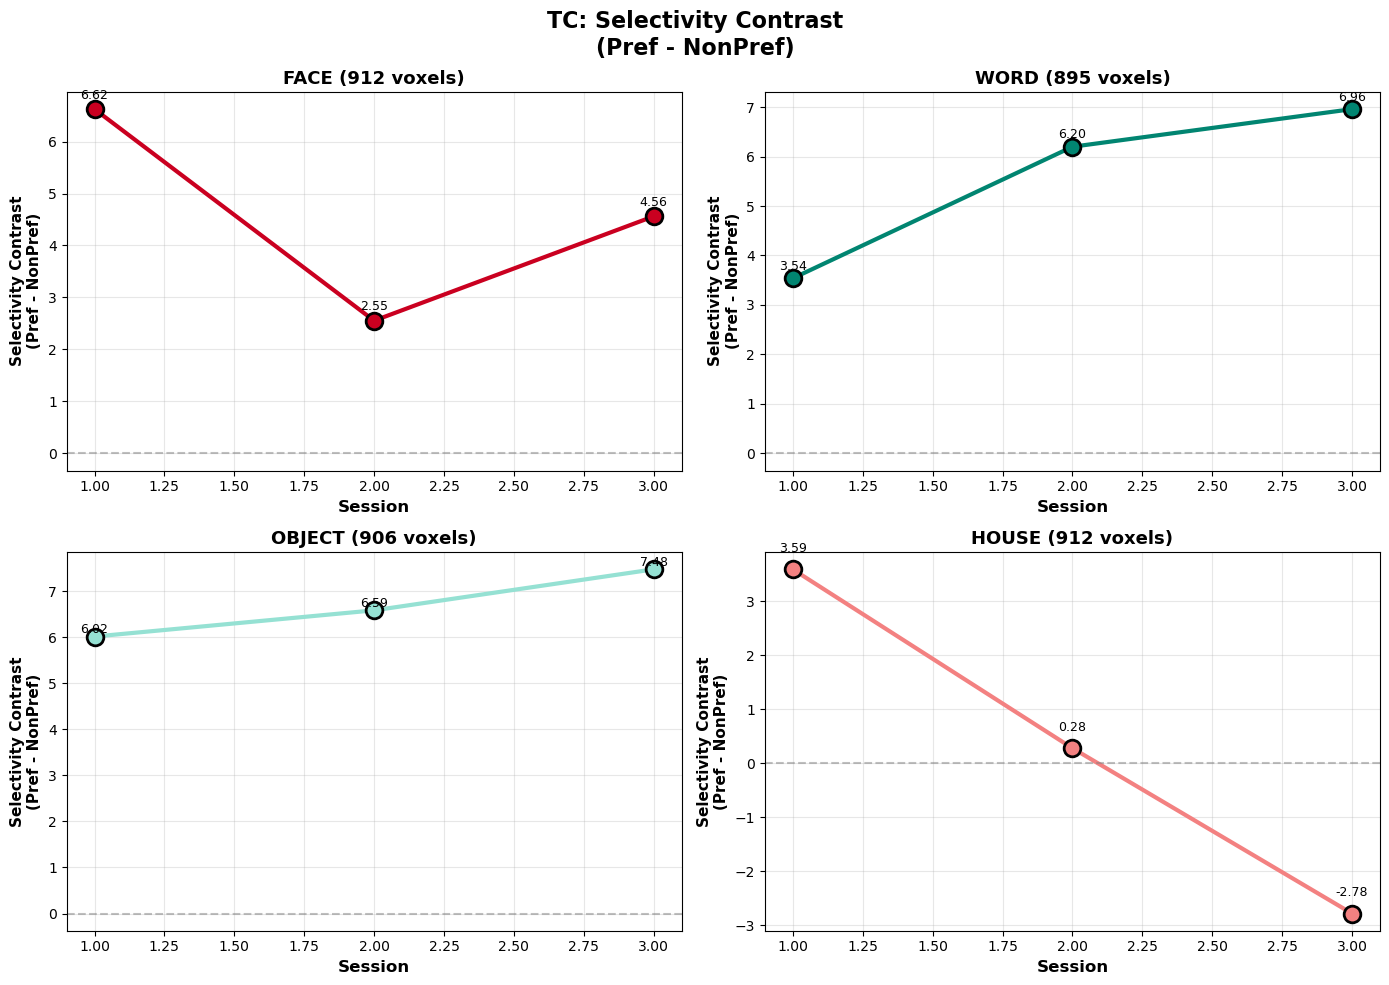


PLOTTING SUM SELECTIVITY


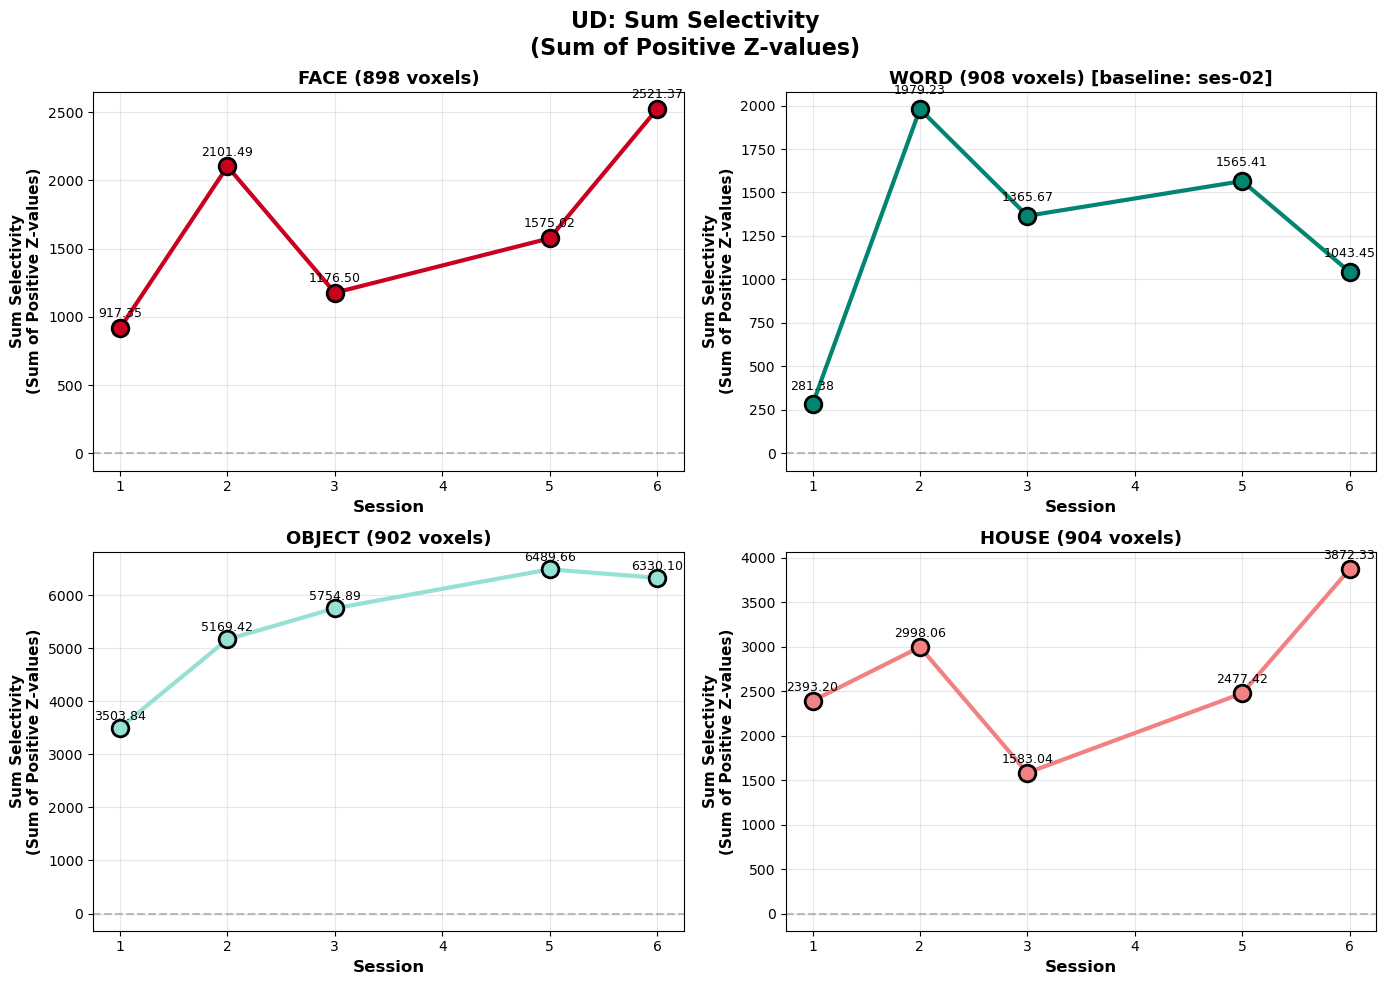

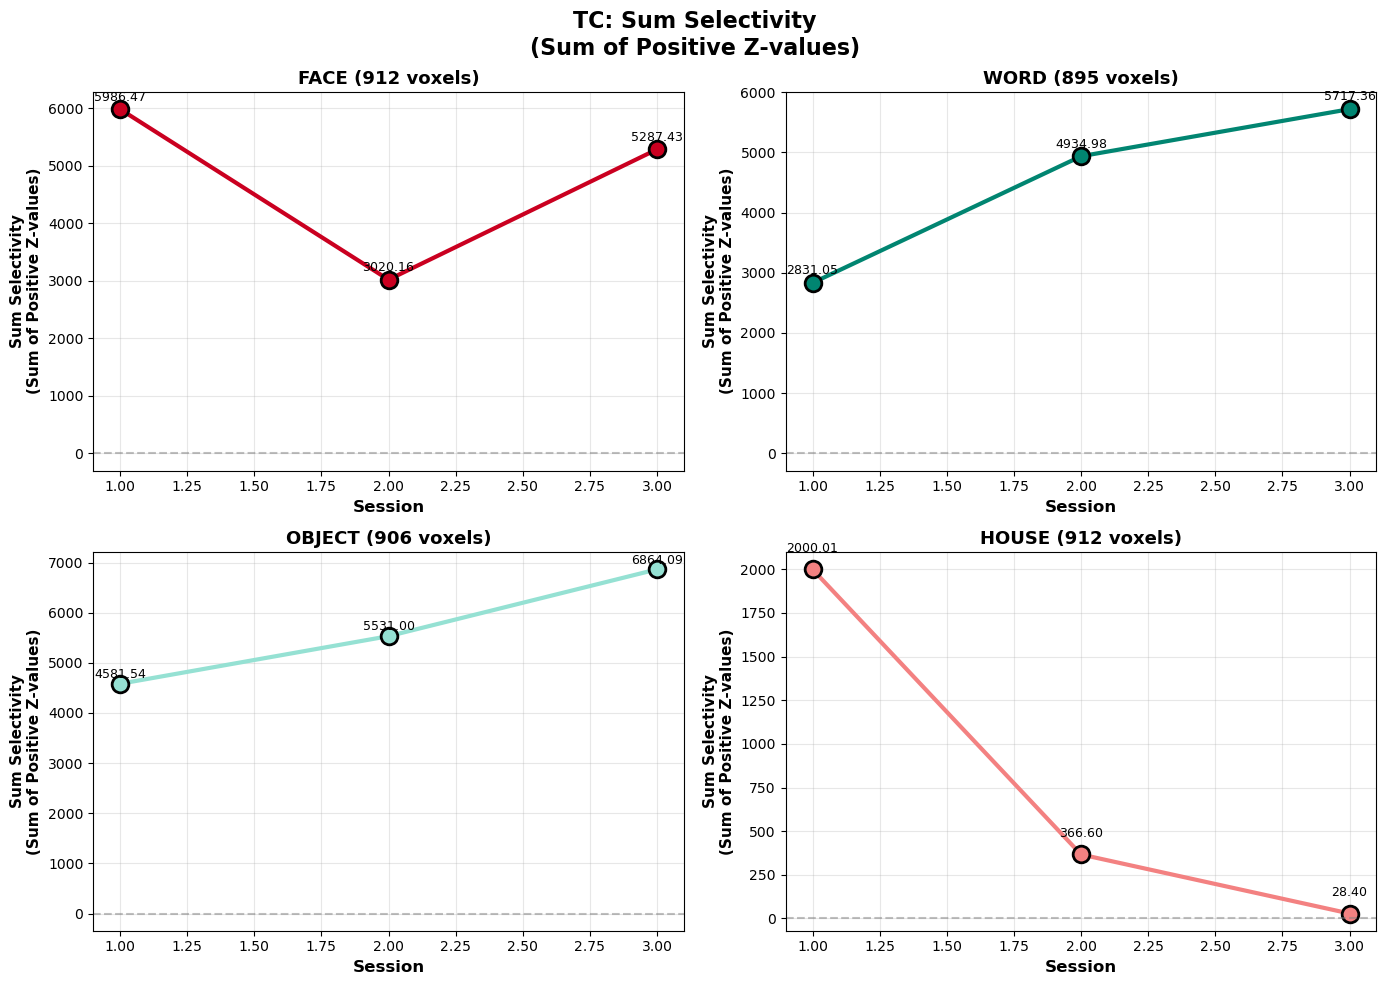


✓ Done! You now have 3 different selectivity plots per subject.


In [19]:
# SELECTIVITY MEASURES: Three options

def extract_selectivity_measures(functional_results):
    """
    Extract selectivity measures from 6mm spheres.
    Computes: Selectivity Index, Contrast, and Sum Selectivity
    """
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    colors = {'face': '#CA0020', 'word': '#018571', 'object': '#95E1D3', 'house': '#F38181'}
    
    results = {}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = SUBJECTS[subject_id]['hemi']
        sessions = SUBJECTS[subject_id]['sessions']
        
        # Get reference for affine
        ref_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        results[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            # Determine baseline session
            if subject_id == 'sub-004' and roi_name == 'word':
                baseline_session = '02'
            else:
                baseline_session = '01'
            
            # Check if we have baseline data
            if roi_name not in functional_results[subject_id]:
                continue
            if baseline_session not in functional_results[subject_id][roi_name]:
                continue
            
            # Get peak and create sphere
            peak = functional_results[subject_id][roi_name][baseline_session]['centroid']
            
            grid_coords = np.array(np.meshgrid(
                np.arange(brain_shape[0]), 
                np.arange(brain_shape[1]), 
                np.arange(brain_shape[2]),
                indexing='ij'
            )).reshape(3, -1).T
            
            grid_world = nib.affines.apply_affine(affine, grid_coords)
            distances = np.linalg.norm(grid_world - peak, axis=1)
            
            sphere_mask = np.zeros(brain_shape, dtype=bool)
            within = grid_coords[distances <= 6]
            for coord in within:
                sphere_mask[coord[0], coord[1], coord[2]] = True
            
            n_voxels = sphere_mask.sum()
            
            print(f"\n{code} - {roi_name.upper()} ({n_voxels} voxels, baseline: ses-{baseline_session})")
            
            results[subject_id][roi_name] = {
                'sessions': {},
                'n_voxels': n_voxels,
                'peak': peak,
                'baseline': baseline_session
            }
            
            # Extract all categories for all sessions
            for session in sessions:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                session_data = {}
                
                # Get z-stats for all 4 categories
                for category, cope_num in category_copes.items():
                    if session == '01':
                        zfile = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
                    else:
                        zfile = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
                    
                    if zfile.exists():
                        zdata = nib.load(zfile).get_fdata()
                        roi_vals = zdata[sphere_mask]
                        roi_vals = roi_vals[np.isfinite(roi_vals)]
                        
                        session_data[category] = {
                            'mean_z': np.mean(roi_vals),
                            'sum_positive': np.sum(roi_vals[roi_vals > 0])
                        }
                
                if len(session_data) == 4:  # All categories present
                    preferred = roi_name
                    nonpreferred = [c for c in ['face', 'word', 'object', 'house'] if c != preferred]
                    
                    pref_mean = session_data[preferred]['mean_z']
                    nonpref_mean = np.mean([session_data[c]['mean_z'] for c in nonpreferred])
                    
                    # Compute selectivity measures
                    selectivity_index = (pref_mean - nonpref_mean) / (pref_mean + nonpref_mean + 1e-10)
                    contrast = pref_mean - nonpref_mean
                    sum_selectivity = session_data[preferred]['sum_positive']
                    
                    results[subject_id][roi_name]['sessions'][session] = {
                        'mean_z': pref_mean,
                        'selectivity_index': selectivity_index,
                        'contrast': contrast,
                        'sum_selectivity': sum_selectivity
                    }
                    
                    print(f"  ses-{session}: mean_z={pref_mean:.2f}, "
                          f"selectivity={selectivity_index:.3f}, "
                          f"contrast={contrast:.2f}, "
                          f"sum={sum_selectivity:.1f}")
    
    return results


def plot_selectivity_measure(results, measure='selectivity_index', output_dir=OUTPUT_DIR):
    """
    Plot a specific selectivity measure.
    
    measure options: 'mean_z', 'selectivity_index', 'contrast', 'sum_selectivity'
    """
    colors = {'face': '#CA0020', 'word': '#018571', 'object': '#95E1D3', 'house': '#F38181'}
    
    measure_labels = {
        'mean_z': 'Mean Z-stat',
        'selectivity_index': 'Selectivity Index\n(Pref-NonPref)/(Pref+NonPref)',
        'contrast': 'Selectivity Contrast\n(Pref - NonPref)',
        'sum_selectivity': 'Sum Selectivity\n(Sum of Positive Z-values)'
    }
    
    for subject_id, rois in results.items():
        code = SUBJECTS[subject_id]['code']
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        roi_idx = 0
        for roi_name in ['face', 'word', 'object', 'house']:
            ax = axes[roi_idx]
            
            if roi_name not in rois:
                ax.text(0.5, 0.5, f'No {roi_name} ROI', ha='center', va='center', fontsize=12)
                ax.set_title(f'{roi_name.upper()}', fontweight='bold')
                ax.set_xlim([0, 10])
                ax.set_ylim([0, 1])
                roi_idx += 1
                continue
            
            roi_data = rois[roi_name]
            
            # Extract values
            sessions = sorted([int(s) for s in roi_data['sessions'].keys()])
            values = [roi_data['sessions'][str(s).zfill(2)][measure] for s in sessions]
            
            # Plot
            ax.plot(sessions, values, 'o-', color=colors[roi_name], 
                   linewidth=3, markersize=12, 
                   markeredgecolor='black', markeredgewidth=2)
            
            # Add value labels
            for x, y in zip(sessions, values):
                ax.text(x, y + 0.05*np.ptp(values), f'{y:.2f}', ha='center', fontsize=9)
            
            if measure == 'selectivity_index':
                ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
                ax.set_ylim([-1, 1])
            elif measure == 'contrast':
                ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
            else:
                ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
            
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Session', fontweight='bold', fontsize=12)
            ax.set_ylabel(measure_labels[measure], fontweight='bold', fontsize=11)
            
            title = f'{roi_name.upper()} ({roi_data["n_voxels"]} voxels)'
            if roi_data['baseline'] != '01':
                title += f' [baseline: ses-{roi_data["baseline"]}]'
            ax.set_title(title, fontweight='bold', fontsize=13)
            
            roi_idx += 1
        
        fig.suptitle(f'{code}: {measure_labels[measure]}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(output_dir / f'{code}_{measure}_6mm.png', dpi=300, bbox_inches='tight')
        plt.show()


# ============================================================================
# RUN IT
# ============================================================================

print("="*70)
print("COMPUTING SELECTIVITY MEASURES")
print("="*70)

selectivity_data = extract_selectivity_measures(golarai_functional_final)

# Plot each measure
print("\n" + "="*70)
print("PLOTTING SELECTIVITY INDEX")
print("="*70)
plot_selectivity_measure(selectivity_data, measure='selectivity_index')

print("\n" + "="*70)
print("PLOTTING CONTRAST")
print("="*70)
plot_selectivity_measure(selectivity_data, measure='contrast')

print("\n" + "="*70)
print("PLOTTING SUM SELECTIVITY")
print("="*70)
plot_selectivity_measure(selectivity_data, measure='sum_selectivity')

print("\n✓ Done! You now have 3 different selectivity plots per subject.")

RSA ANALYSIS WITH 6MM SPHERES

UD: Extracting Beta Patterns for RSA (6mm spheres)

FACE ROI (898 voxels, baseline: ses-01):
  ses-01: 898 voxels × 4 categories
  ses-02: 898 voxels × 4 categories
  ses-03: 898 voxels × 4 categories
  ses-05: 898 voxels × 4 categories
  ses-06: 898 voxels × 4 categories

WORD ROI (908 voxels, baseline: ses-02):
  ses-01: 908 voxels × 4 categories
  ses-02: 908 voxels × 4 categories
  ses-03: 908 voxels × 4 categories
  ses-05: 908 voxels × 4 categories
  ses-06: 908 voxels × 4 categories

OBJECT ROI (902 voxels, baseline: ses-01):
  ses-01: 902 voxels × 4 categories
  ses-02: 902 voxels × 4 categories
  ses-03: 902 voxels × 4 categories
  ses-05: 902 voxels × 4 categories
  ses-06: 902 voxels × 4 categories

HOUSE ROI (904 voxels, baseline: ses-01):
  ses-01: 904 voxels × 4 categories
  ses-02: 904 voxels × 4 categories
  ses-03: 904 voxels × 4 categories
  ses-05: 904 voxels × 4 categories
  ses-06: 904 voxels × 4 categories

TC: Extracting Beta Patter

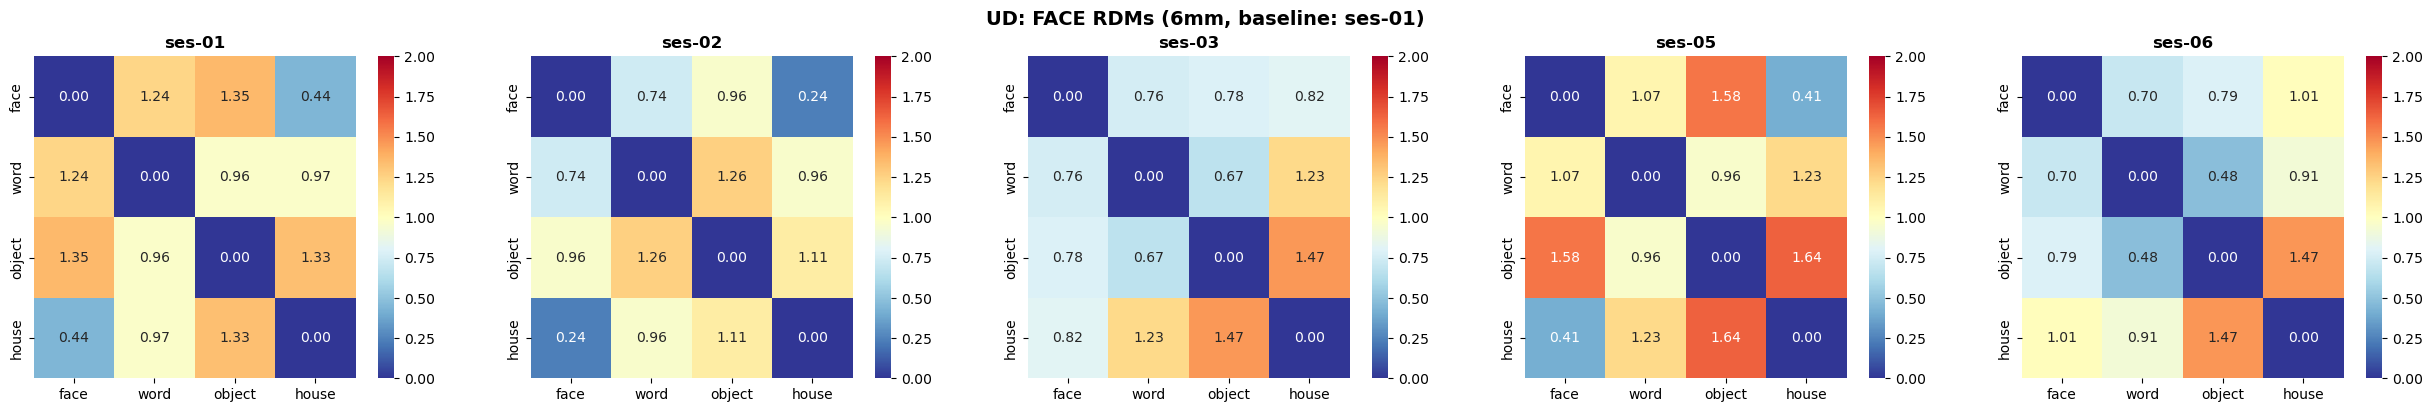

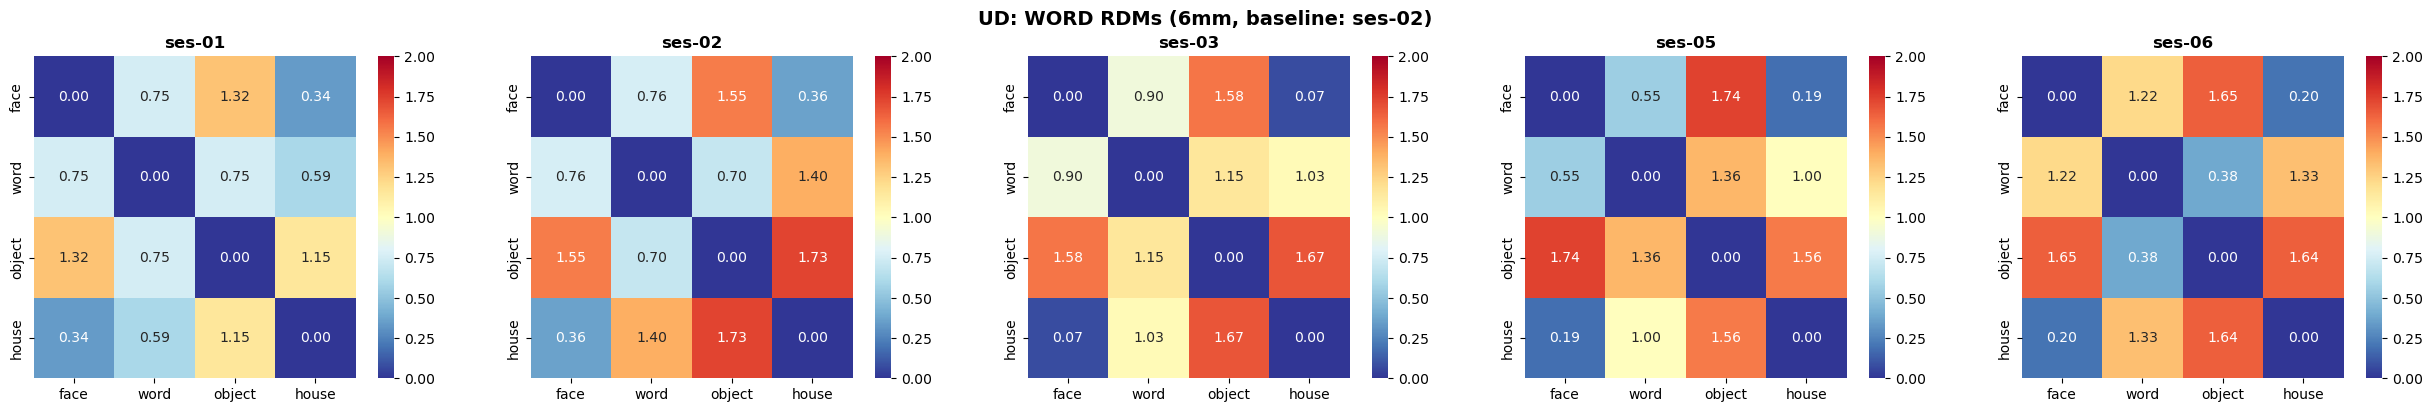

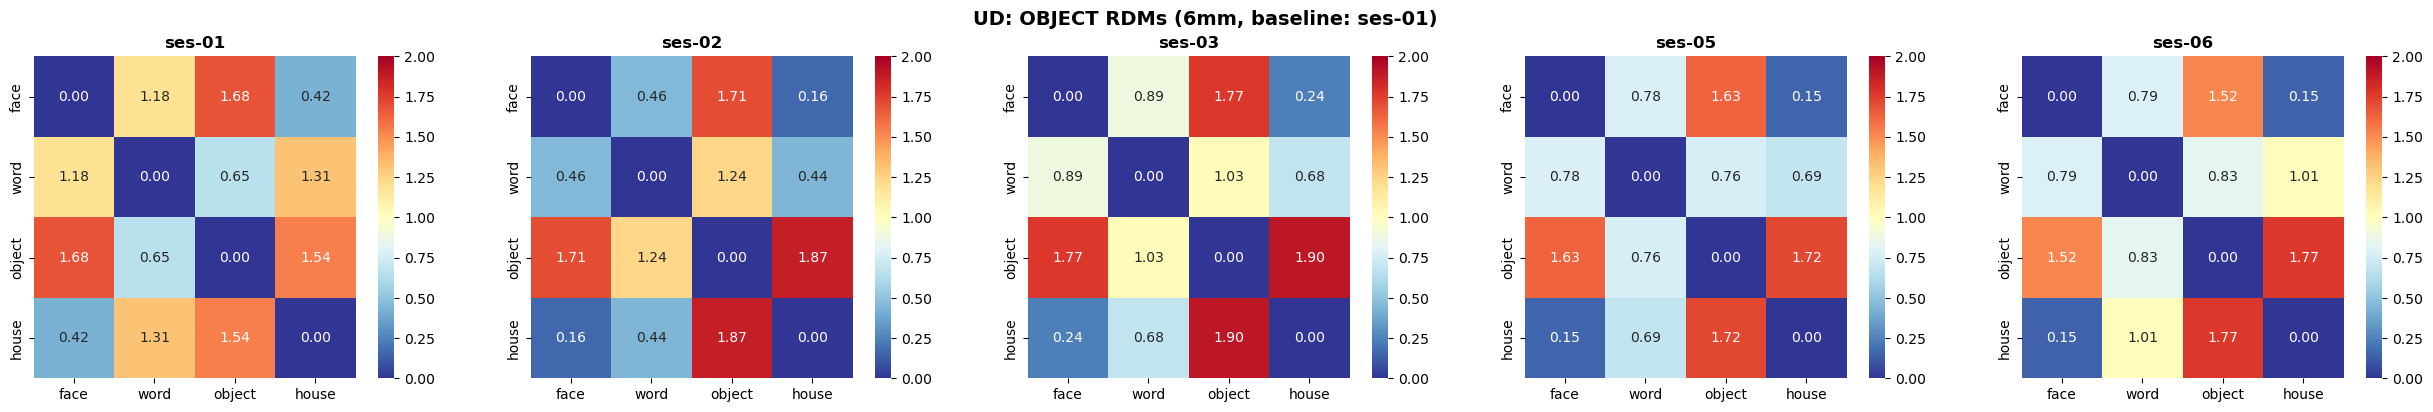

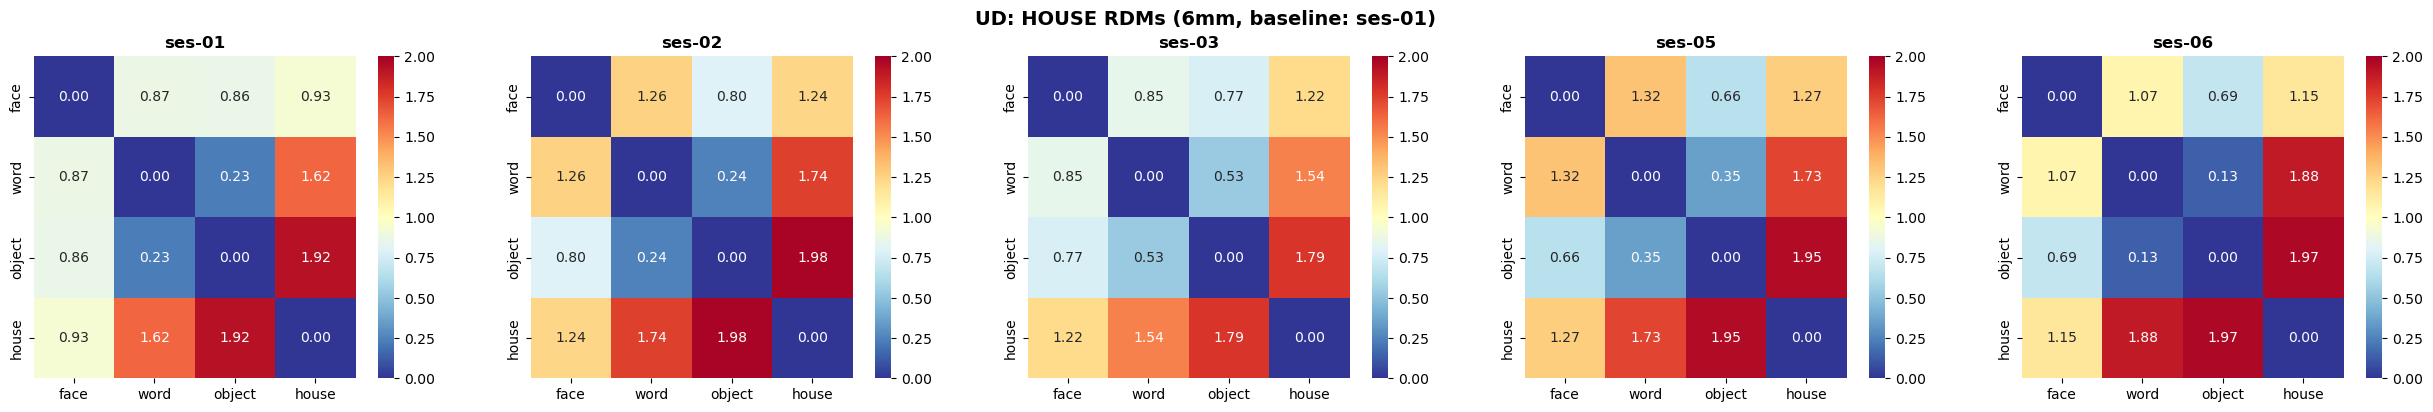

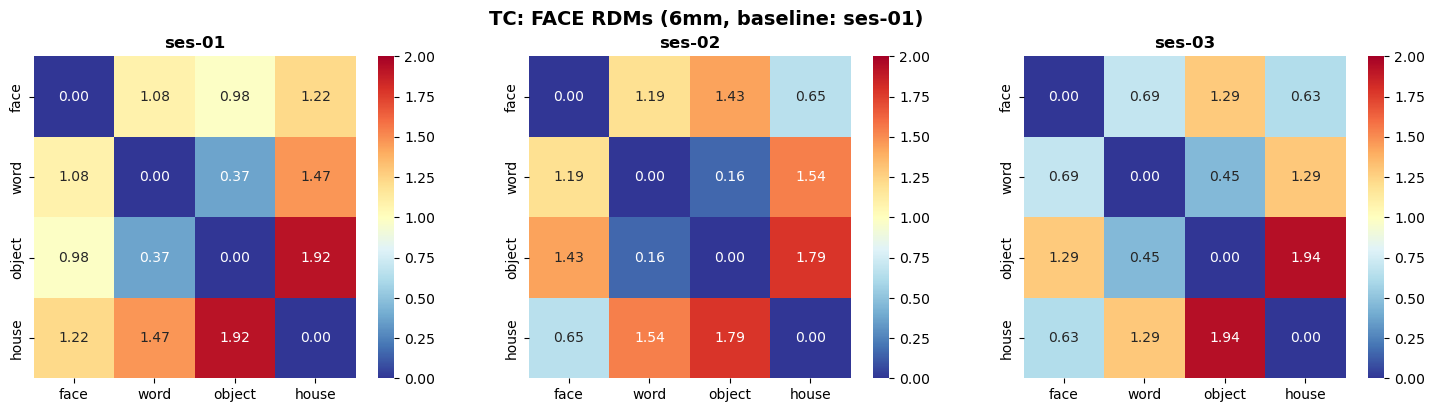

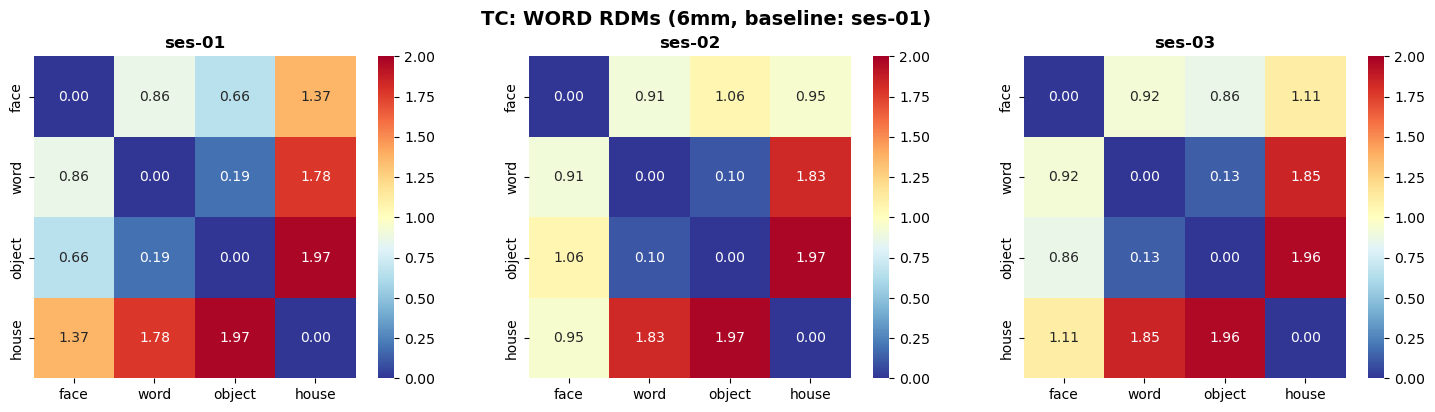

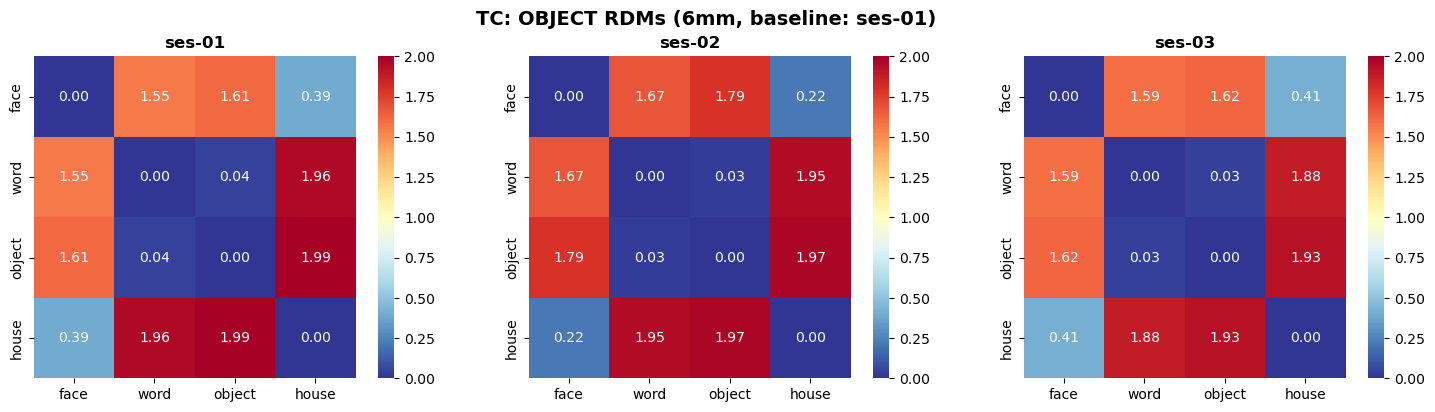

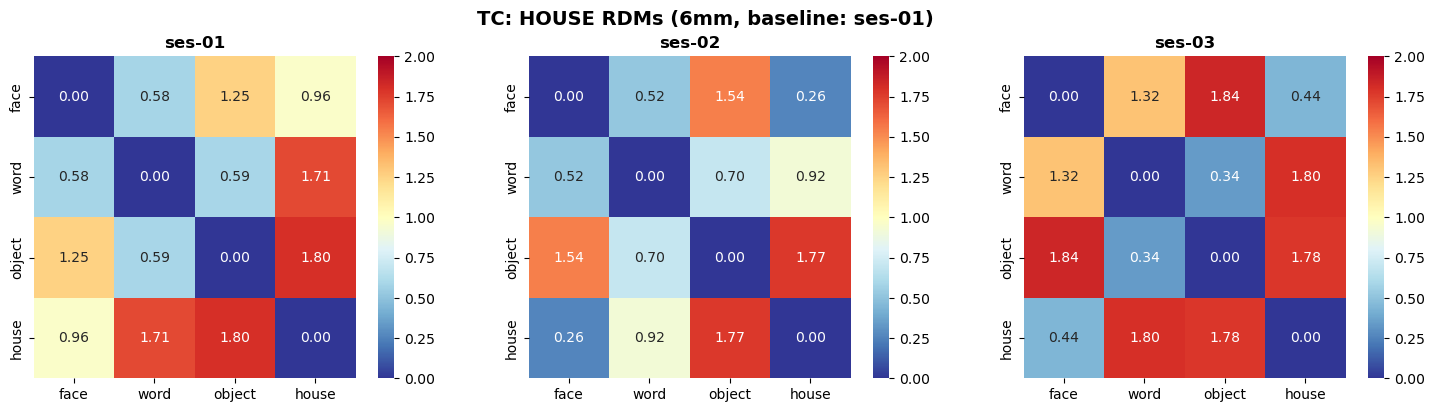

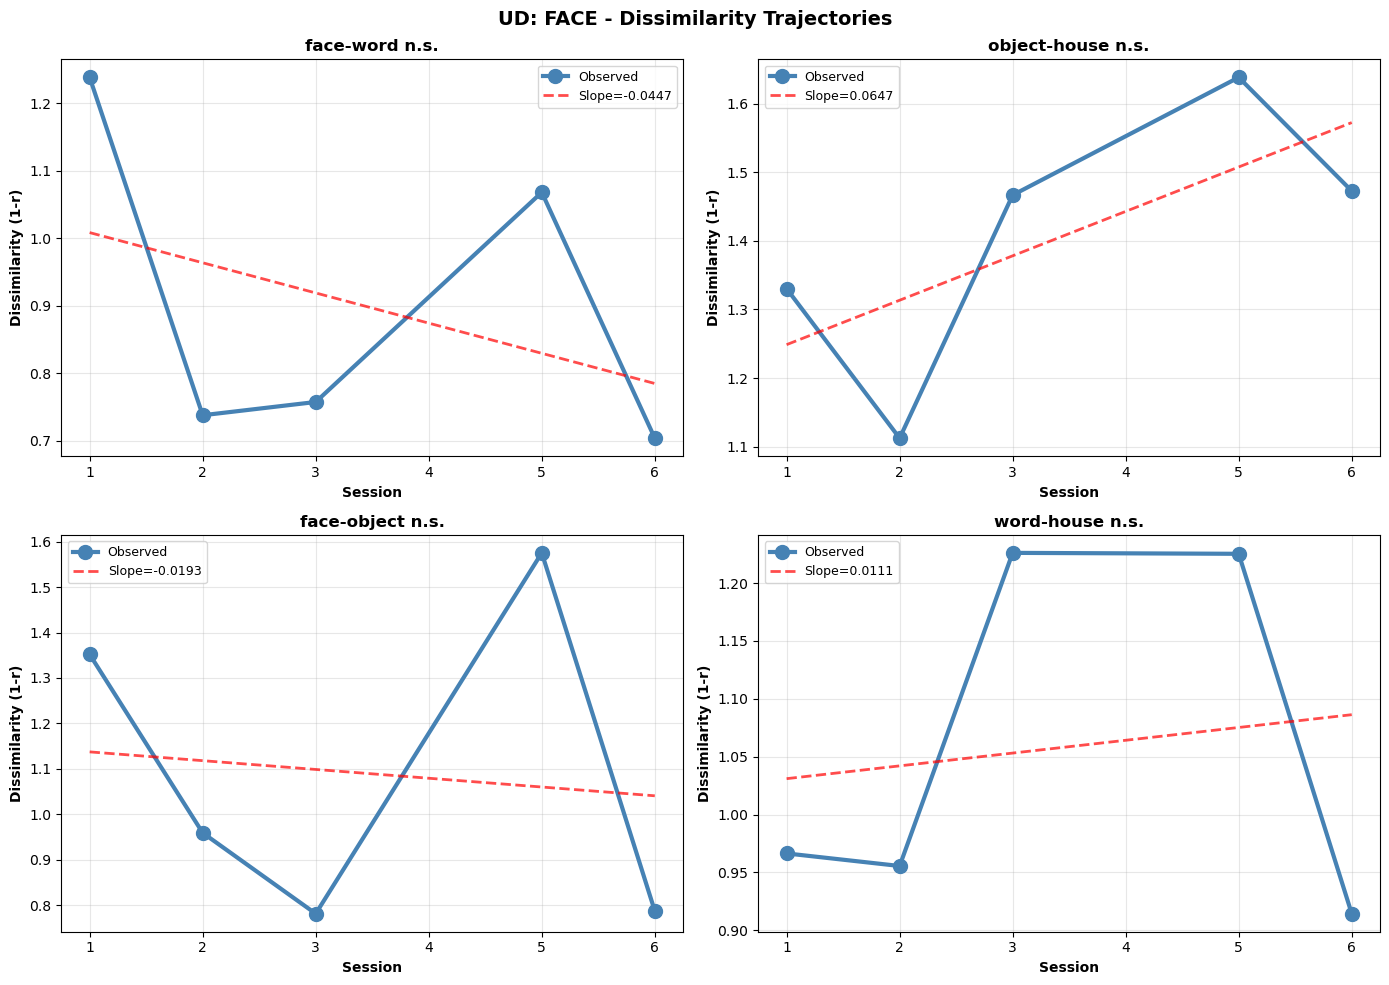

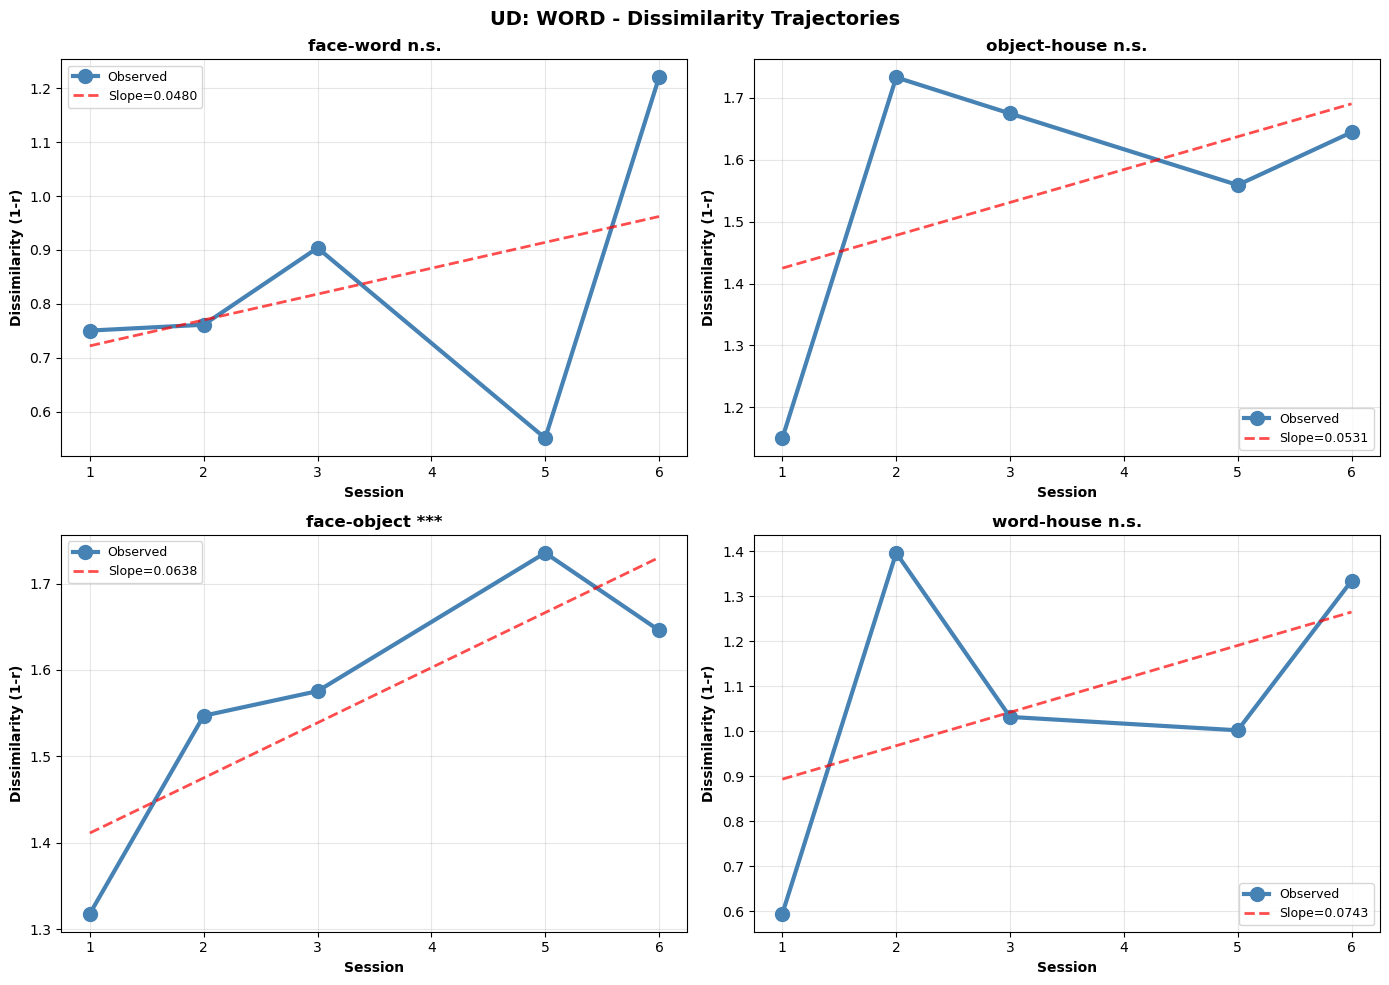

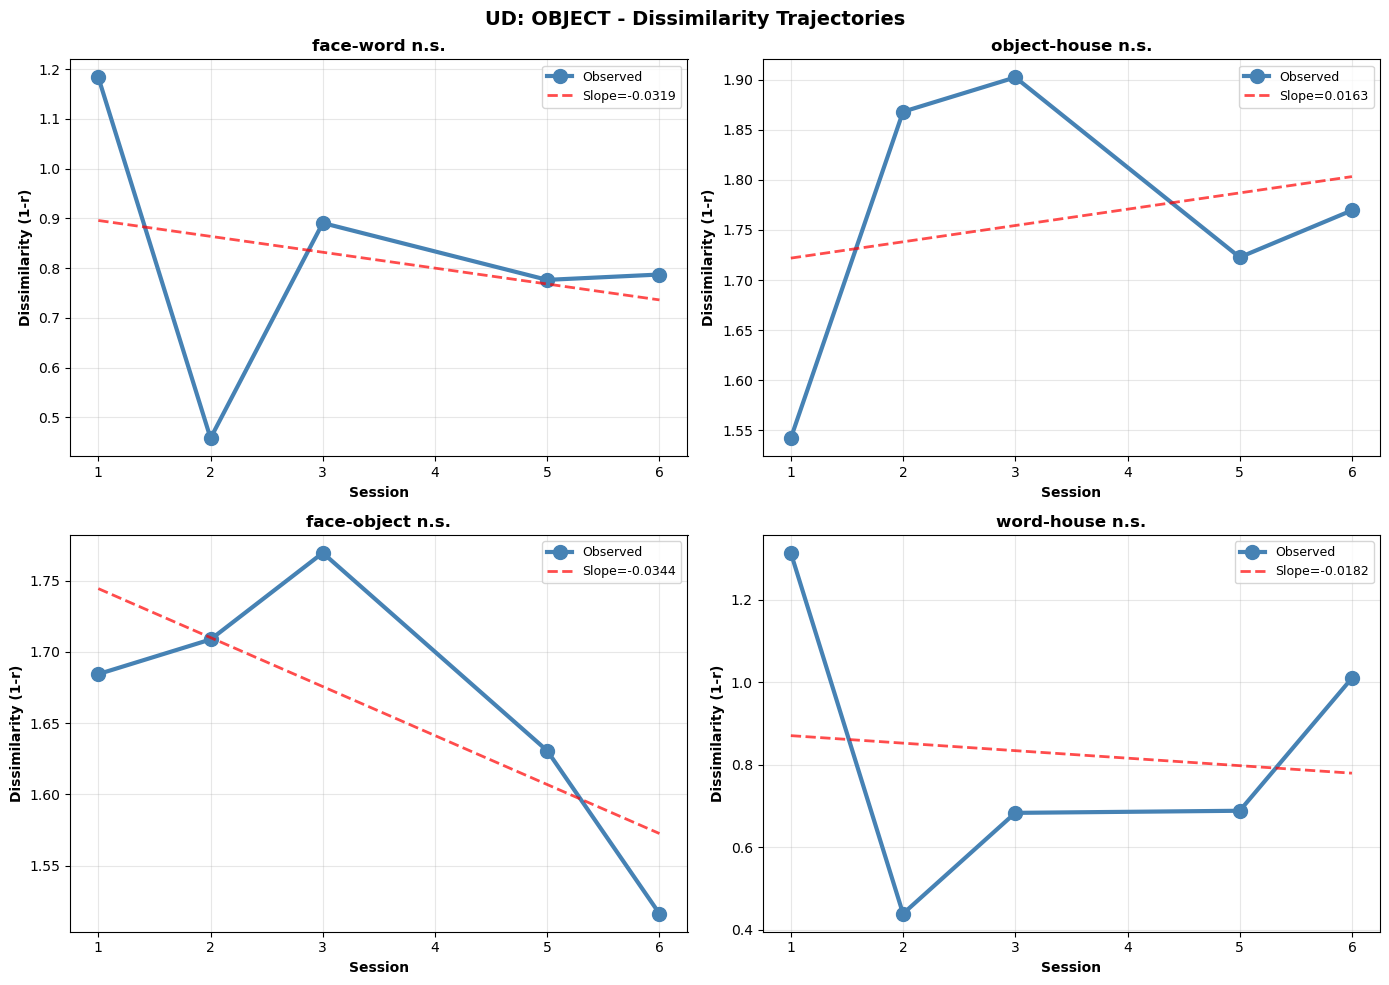

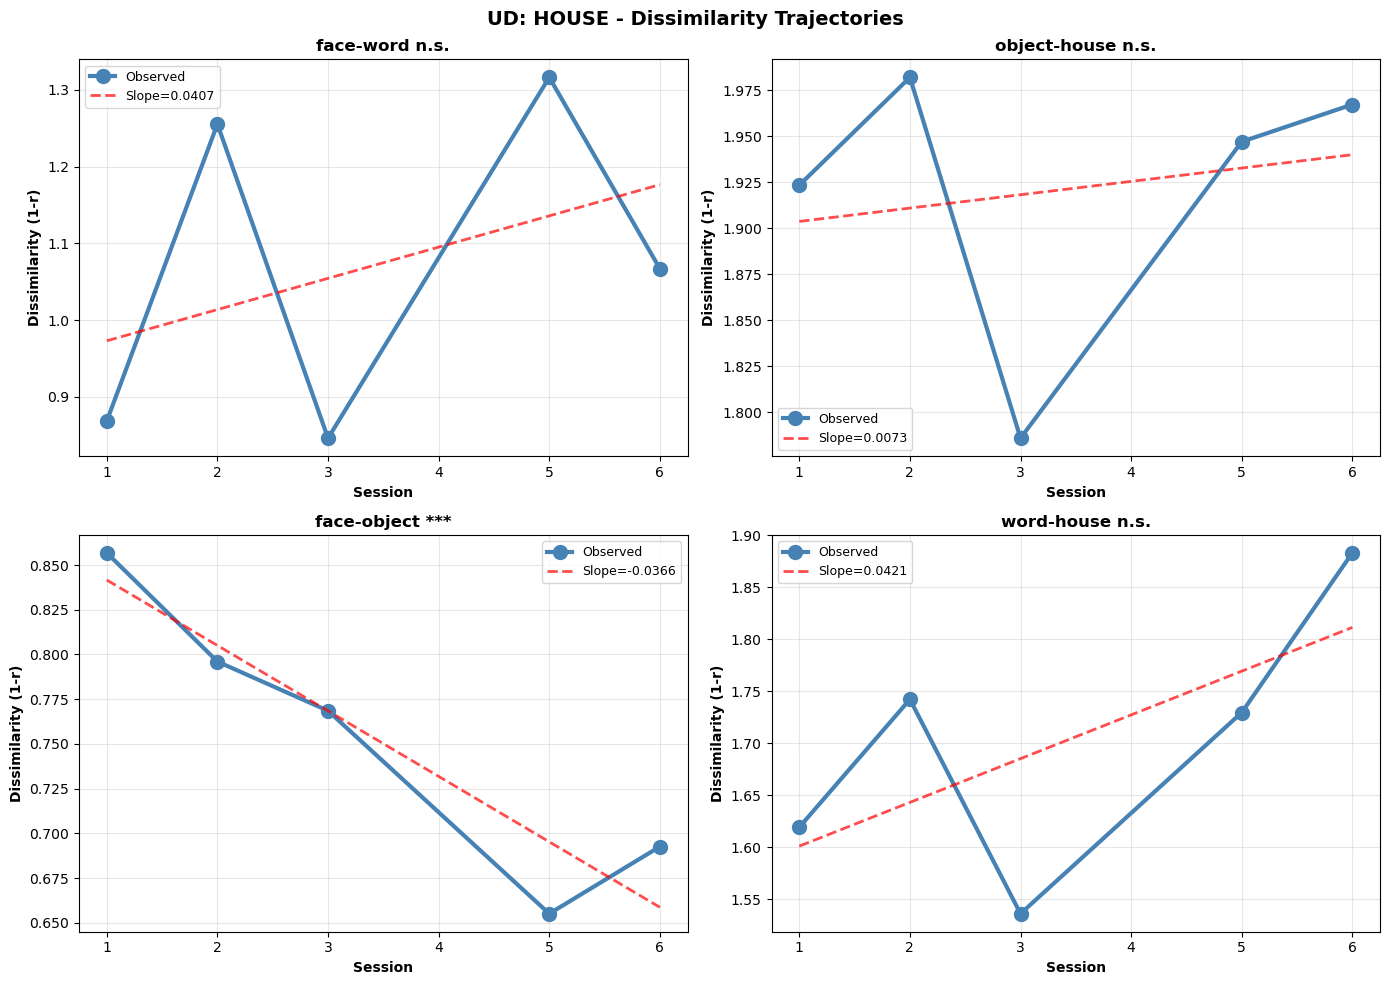

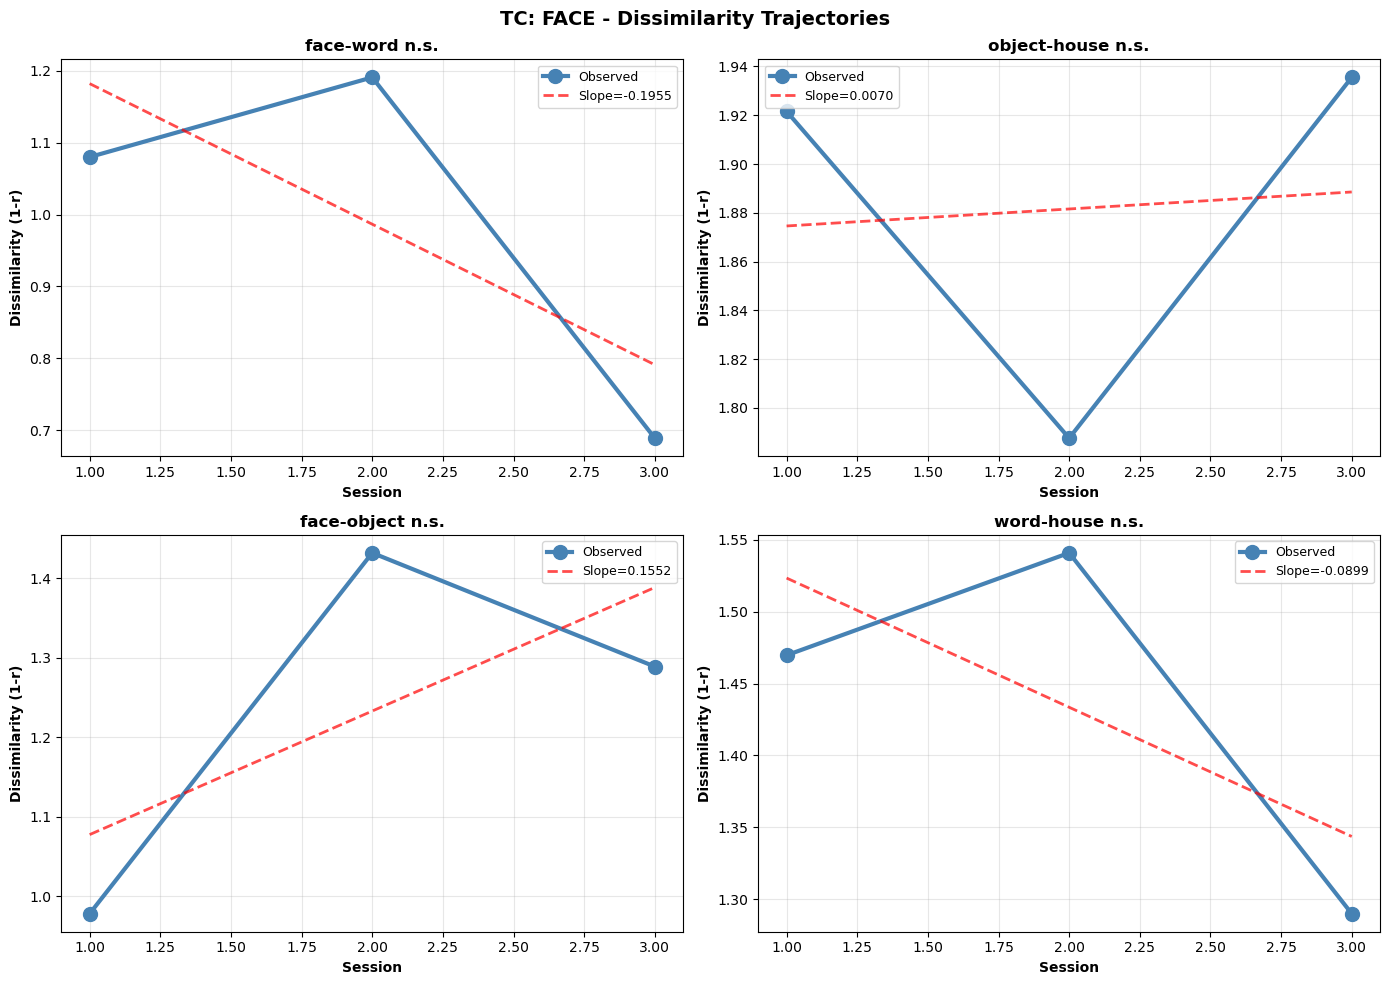

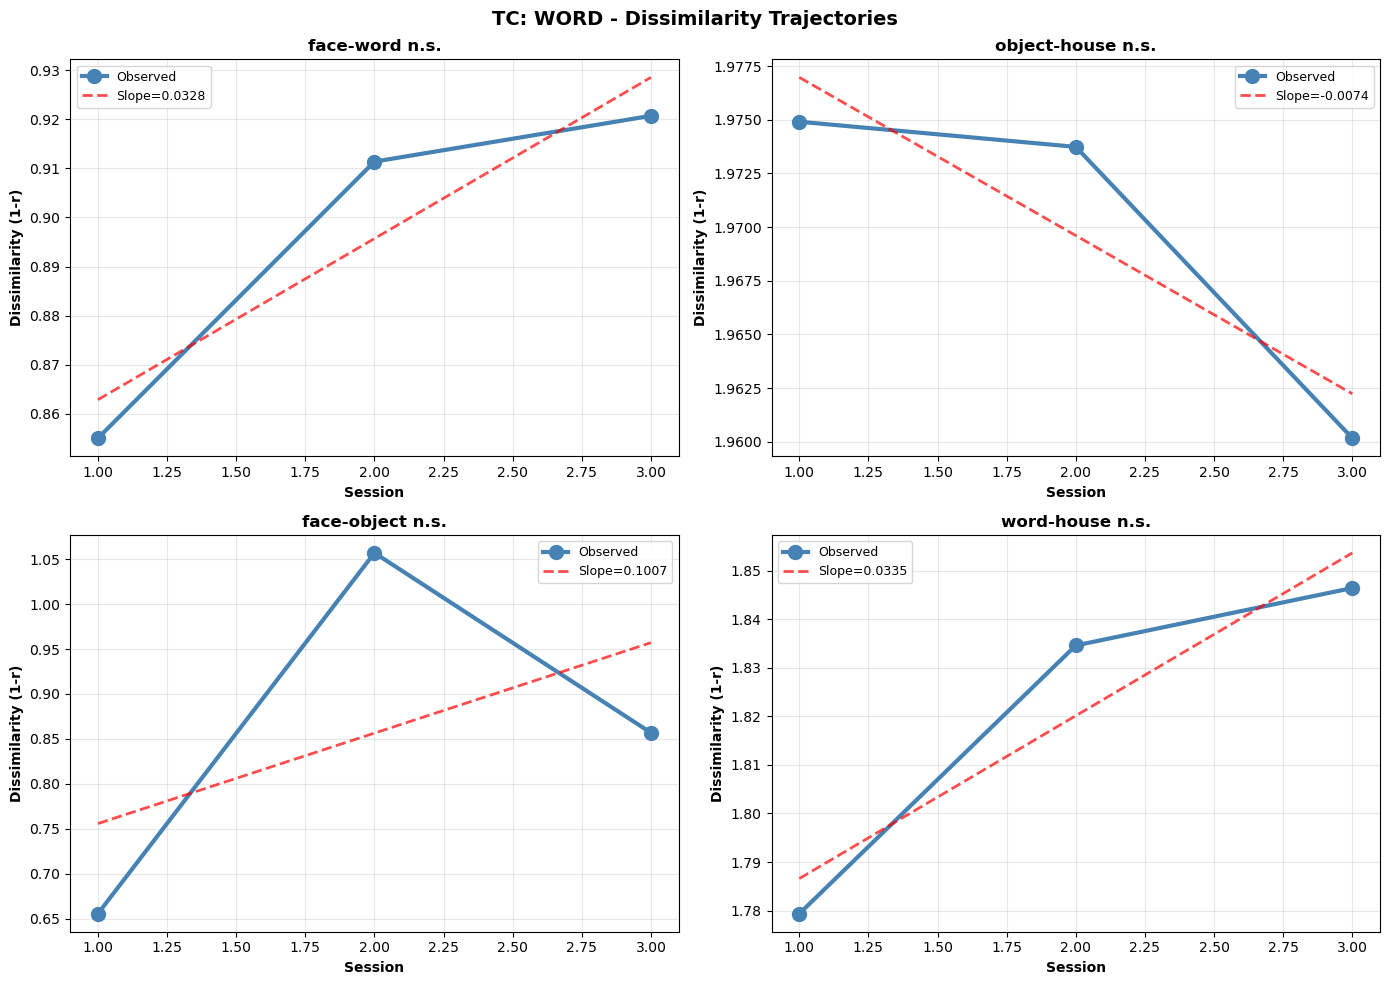

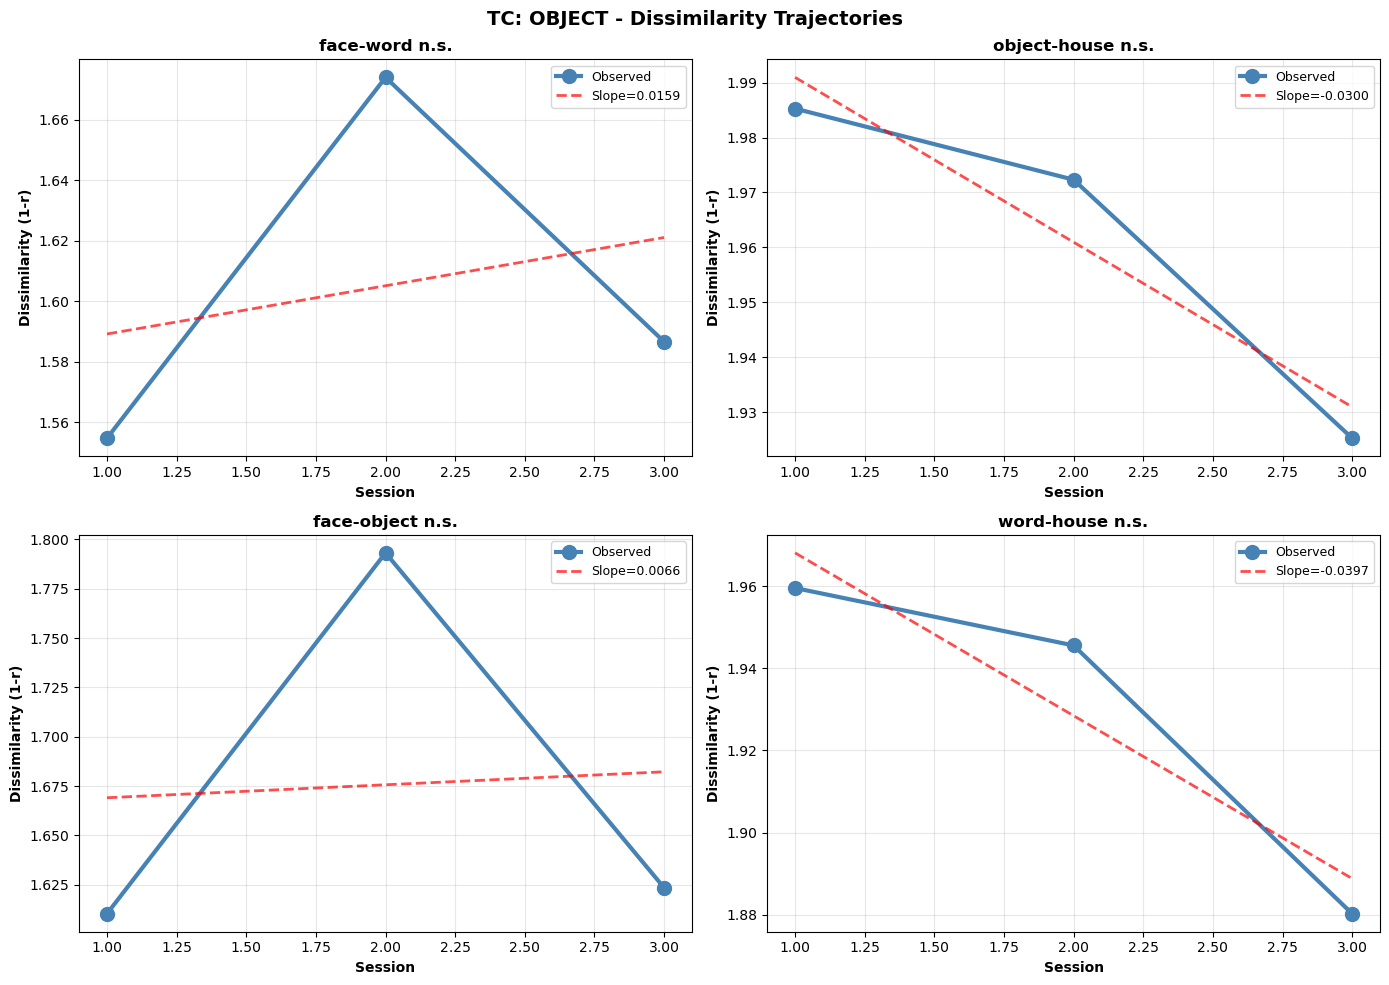

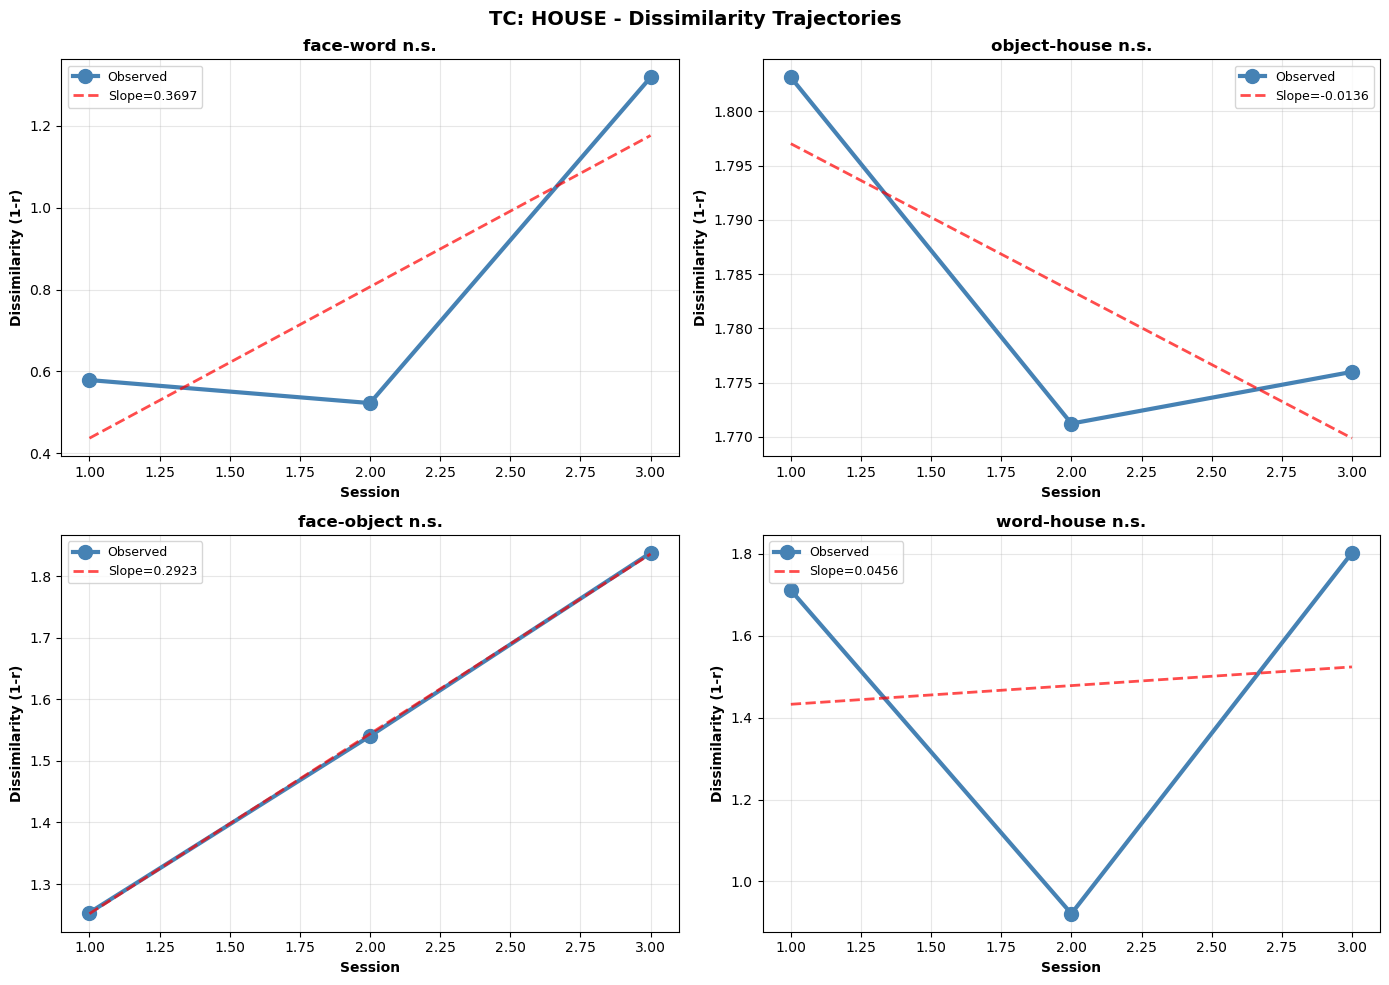

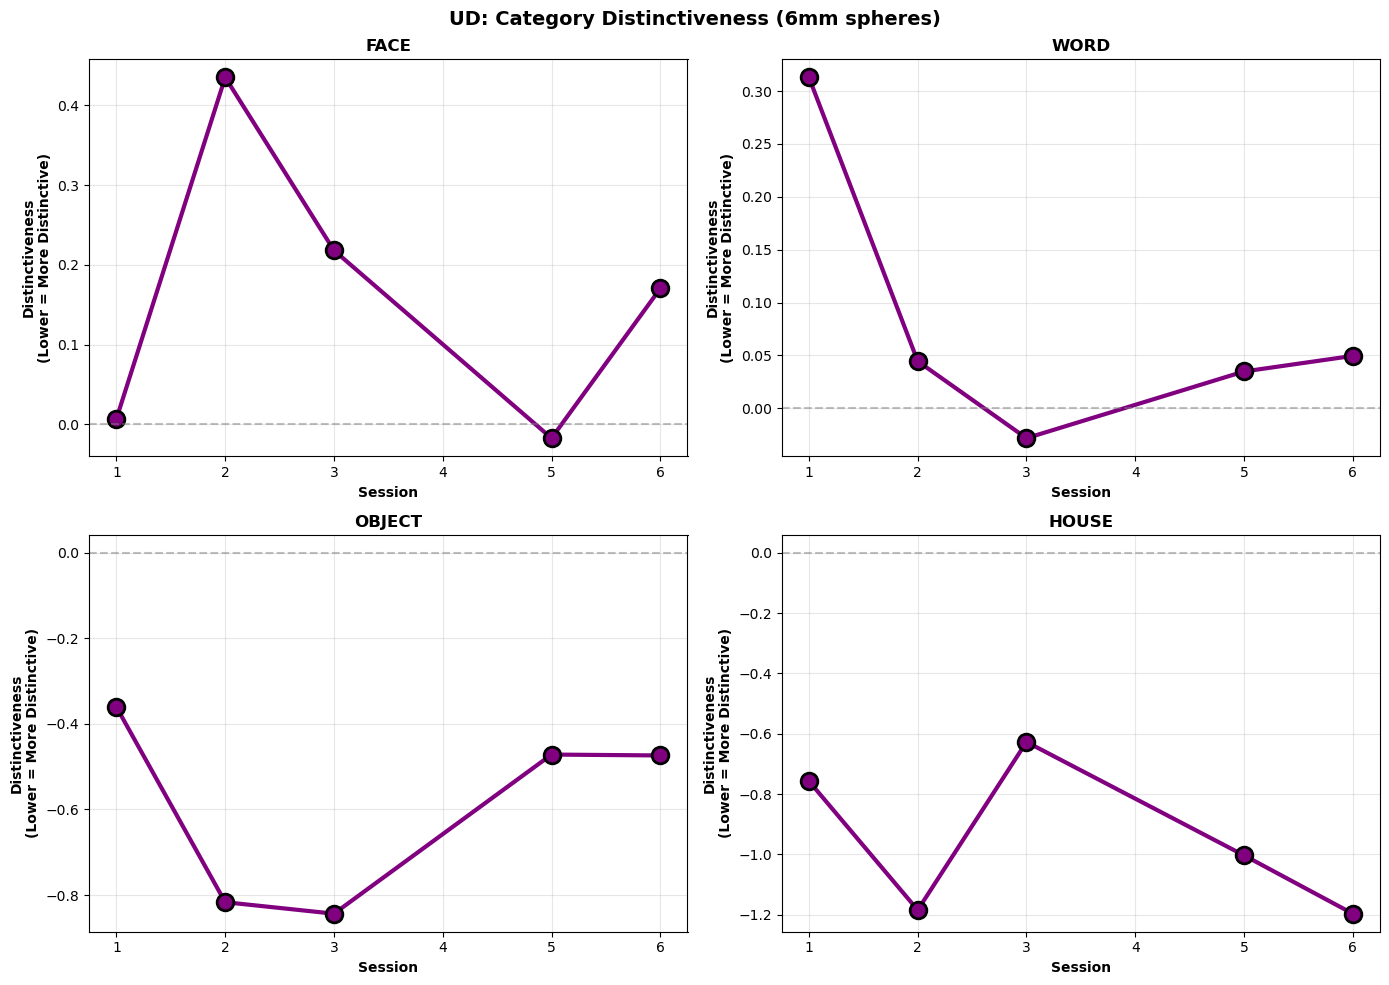

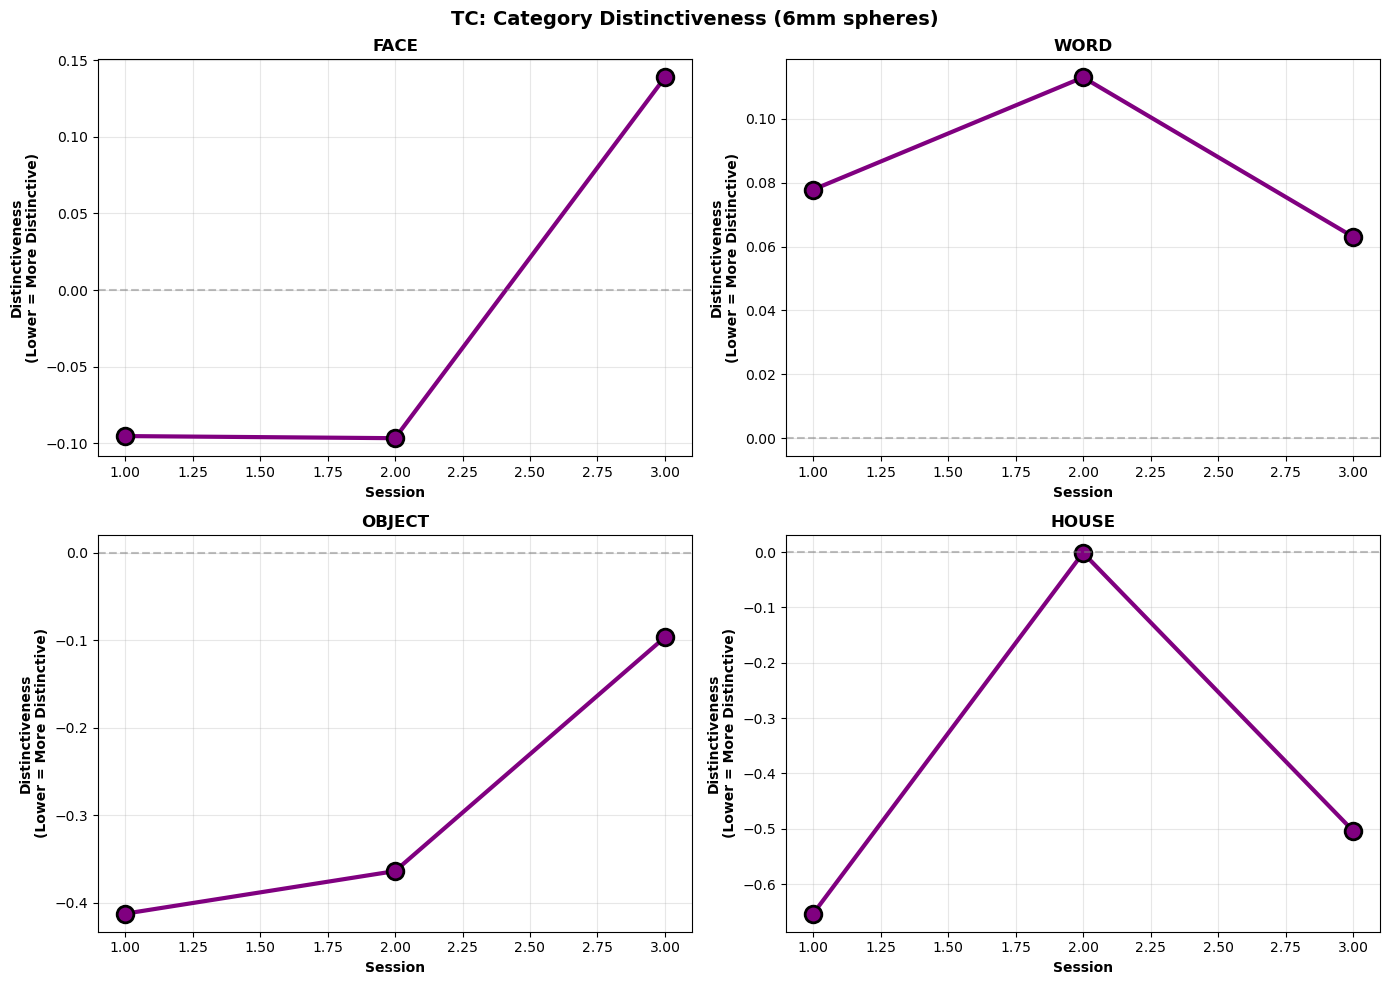

In [22]:
# CELL 6: RSA Analysis (FIXED - 6mm spheres, UD word baseline)

import numpy as np
from scipy.stats import pearsonr
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# ============================================================================
# PART 1: EXTRACT BETA PATTERNS FROM 6MM SPHERES
# ============================================================================

def create_6mm_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create a 6mm sphere around a peak."""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), 
        np.arange(brain_shape[1]), 
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d


def extract_beta_patterns_from_sphere(subject_id, session, sphere_mask, category_copes):
    """Extract beta values (cope estimates) from a 6mm sphere for all categories."""
    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    
    beta_patterns = []
    valid_categories = []
    
    for category, cope_num in category_copes.items():
        # Different file names for ses-01 vs other sessions
        if session == '01':
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
        else:
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1_ses01.nii.gz'
        
        if not cope_file.exists():
            continue
        
        # Load cope (parameter estimates = betas)
        cope_data = nib.load(cope_file).get_fdata()
        
        # Extract values from ROI
        roi_betas = cope_data[sphere_mask]
        
        # Remove NaN/Inf values
        roi_betas = roi_betas[np.isfinite(roi_betas)]
        
        if len(roi_betas) > 0:
            beta_patterns.append(roi_betas)
            valid_categories.append(category)
    
    if len(beta_patterns) == 0:
        return None, None
    
    # Ensure all have same number of voxels
    min_voxels = min(len(b) for b in beta_patterns)
    beta_patterns = [b[:min_voxels] for b in beta_patterns]
    
    # Shape: (n_voxels, n_categories)
    beta_matrix = np.column_stack(beta_patterns)
    
    return beta_matrix, valid_categories


def compute_rdm(beta_matrix, fisher_transform=True):
    """Compute Representational Dissimilarity Matrix."""
    # Compute correlation between category patterns
    correlation_matrix = np.corrcoef(beta_matrix.T)
    
    # Convert to dissimilarity
    rdm = 1 - correlation_matrix
    
    if fisher_transform:
        # Fisher z-transform
        correlation_matrix_fisher = np.arctanh(np.clip(correlation_matrix, -0.999, 0.999))
        return rdm, correlation_matrix_fisher
    else:
        return rdm, correlation_matrix


def extract_all_rdms_6mm(functional_results):
    """Extract RDMs from 6mm spheres for all subjects, sessions, and categories."""
    all_rdms = {}
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = SUBJECTS[subject_id]['hemi']
        sessions = SUBJECTS[subject_id]['sessions']
        
        # Get reference for affine
        ref_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        print(f"\n{'='*70}")
        print(f"{code}: Extracting Beta Patterns for RSA (6mm spheres)")
        print(f"{'='*70}")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            # Determine baseline session
            if subject_id == 'sub-004' and roi_name == 'word':
                baseline_session = '02'
            else:
                baseline_session = '01'
            
            # Check if we have baseline data
            if roi_name not in functional_results[subject_id]:
                continue
            if baseline_session not in functional_results[subject_id][roi_name]:
                continue
            
            # Get peak and create 6mm sphere
            peak = functional_results[subject_id][roi_name][baseline_session]['centroid']
            sphere_mask = create_6mm_sphere(peak, affine, brain_shape, radius=6)
            n_voxels = sphere_mask.sum()
            
            print(f"\n{roi_name.upper()} ROI ({n_voxels} voxels, baseline: ses-{baseline_session}):")
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'beta_patterns': {},
                'valid_categories': None,
                'n_voxels': n_voxels,
                'baseline': baseline_session
            }
            
            for session in sessions:
                beta_matrix, valid_cats = extract_beta_patterns_from_sphere(
                    subject_id, session, sphere_mask, category_copes
                )
                
                if beta_matrix is None:
                    print(f"  ses-{session}: No data")
                    continue
                
                # Compute RDM with Fisher transform
                rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                
                all_rdms[subject_id][roi_name]['rdms'][session] = rdm
                all_rdms[subject_id][roi_name]['correlation_matrices'][session] = corr_matrix_fisher
                all_rdms[subject_id][roi_name]['beta_patterns'][session] = beta_matrix
                all_rdms[subject_id][roi_name]['valid_categories'] = valid_cats
                
                print(f"  ses-{session}: {beta_matrix.shape[0]} voxels × {beta_matrix.shape[1]} categories")
    
    return all_rdms


# ============================================================================
# PART 2: CATEGORY DISTINCTIVENESS
# ============================================================================

def compute_distinctiveness_scores(all_rdms):
    """Compute category distinctiveness."""
    distinctiveness_results = {}
    
    preferred_map = {
        'face': ('face', ['word', 'object', 'house']),
        'word': ('word', ['face', 'object', 'house']),
        'object': ('object', ['face', 'word', 'house']),
        'house': ('house', ['face', 'word', 'object'])
    }
    
    for subject_id, categories in all_rdms.items():
        code = SUBJECTS[subject_id]['code']
        distinctiveness_results[subject_id] = {}
        
        print(f"\n{'='*70}")
        print(f"{code}: Category Distinctiveness")
        print(f"{'='*70}")
        
        for roi_name, roi_data in categories.items():
            if 'correlation_matrices' not in roi_data or not roi_data['correlation_matrices']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None:
                continue
            
            preferred_cat, nonpreferred_cats = preferred_map[roi_name]
            
            try:
                pref_idx = valid_cats.index(preferred_cat)
                nonpref_indices = [valid_cats.index(c) for c in nonpreferred_cats if c in valid_cats]
            except ValueError:
                continue
            
            print(f"\n{roi_name.upper()} (preferred: {preferred_cat}):")
            
            distinctiveness_results[subject_id][roi_name] = {}
            
            for session, corr_matrix in roi_data['correlation_matrices'].items():
                pref_vs_nonpref = corr_matrix[pref_idx, nonpref_indices]
                mean_corr_fisher = np.mean(pref_vs_nonpref)
                
                distinctiveness_results[subject_id][roi_name][session] = {
                    'distinctiveness_score': mean_corr_fisher,
                    'individual_correlations': pref_vs_nonpref
                }
                
                print(f"  ses-{session}: {mean_corr_fisher:.3f} (lower = more distinctive)")
    
    return distinctiveness_results


# ============================================================================
# PART 3: DISSIMILARITY TRAJECTORIES WITH BOOTSTRAPPING
# ============================================================================

def compute_dissimilarity_trajectories(all_rdms):
    """Track specific category-pair dissimilarities over time with bootstrap statistics."""
    trajectory_results = {}
    
    category_pairs = [
        ('face', 'word'),
        ('object', 'house'),
        ('face', 'object'),
        ('word', 'house')
    ]
    
    for subject_id, categories in all_rdms.items():
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        print(f"\n{'='*70}")
        print(f"{code}: Dissimilarity Trajectories")
        print(f"{'='*70}")
        
        trajectory_results[subject_id] = {}
        
        for roi_name, roi_data in categories.items():
            if not roi_data['rdms']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            print(f"\n{roi_name.upper()}:")
            trajectory_results[subject_id][roi_name] = {}
            
            for cat1, cat2 in category_pairs:
                if cat1 not in valid_cats or cat2 not in valid_cats:
                    continue
                
                idx1 = valid_cats.index(cat1)
                idx2 = valid_cats.index(cat2)
                
                # Extract dissimilarity over sessions
                session_list = []
                dissim_list = []
                
                for session in sessions:
                    if session in roi_data['rdms']:
                        rdm = roi_data['rdms'][session]
                        dissim = rdm[idx1, idx2]
                        session_list.append(int(session))
                        dissim_list.append(dissim)
                
                if len(session_list) < 2:
                    continue
                
                # Linear regression
                slope, intercept, r_val, p_val, std_err = linregress(session_list, dissim_list)
                
                # Bootstrap null distribution
                n_bootstraps = 1000
                null_slopes = []
                
                for _ in range(n_bootstraps):
                    shuffled_dissim = np.random.permutation(dissim_list)
                    null_slope = linregress(session_list, shuffled_dissim)[0]
                    null_slopes.append(null_slope)
                
                ci_lower = np.percentile(null_slopes, 2.5)
                ci_upper = np.percentile(null_slopes, 97.5)
                
                significant = slope < ci_lower or slope > ci_upper
                
                trajectory_results[subject_id][roi_name][f'{cat1}-{cat2}'] = {
                    'sessions': session_list,
                    'dissimilarities': dissim_list,
                    'slope': slope,
                    'intercept': intercept,
                    'r_value': r_val,
                    'p_value': p_val,
                    'null_slopes': null_slopes,
                    'ci_95': (ci_lower, ci_upper),
                    'significant': significant
                }
                
                sig_marker = "***" if significant else ""
                print(f"  {cat1}-{cat2}: slope={slope:.4f} {sig_marker}")
    
    return trajectory_results


# ============================================================================
# PART 4: SIMPLIFIED PLOTTING
# ============================================================================

def plot_rdm_heatmaps_simple(all_rdms, output_dir):
    """Plot RDM heatmaps."""
    for subject_id, categories in all_rdms.items():
        code = SUBJECTS[subject_id]['code']
        
        for roi_name, roi_data in categories.items():
            if not roi_data['rdms']:
                continue
            
            sessions = sorted(roi_data['rdms'].keys())
            valid_cats = roi_data['valid_categories']
            
            n_sessions = len(sessions)
            fig, axes = plt.subplots(1, n_sessions, figsize=(5*n_sessions, 4))
            
            if n_sessions == 1:
                axes = [axes]
            
            for idx, session in enumerate(sessions):
                rdm = roi_data['rdms'][session]
                
                sns.heatmap(rdm, ax=axes[idx], cmap='RdYlBu_r', 
                           xticklabels=valid_cats, yticklabels=valid_cats,
                           vmin=0, vmax=2, cbar=True, square=True,
                           annot=True, fmt='.2f')
                axes[idx].set_title(f'ses-{session}', fontweight='bold')
            
            baseline = roi_data['baseline']
            title = f'{code}: {roi_name.upper()} RDMs (6mm, baseline: ses-{baseline})'
            fig.suptitle(title, fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(output_dir / f'{code}_{roi_name}_rdms_6mm.png', dpi=300, bbox_inches='tight')
            #plt.close()


def plot_dissimilarity_trajectories_fixed(trajectory_results, output_dir):
    """Plot dissimilarity changes over time (FIXED intercept bug)."""
    for subject_id, rois in trajectory_results.items():
        code = SUBJECTS[subject_id]['code']
        
        for roi_name, pairs in rois.items():
            if not pairs:
                continue
            
            n_pairs = len(pairs)
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            axes = axes.flatten()
            
            for idx, (pair_name, data) in enumerate(pairs.items()):
                if idx >= 4:
                    break
                
                ax = axes[idx]
                
                # Plot trajectory
                ax.plot(data['sessions'], data['dissimilarities'], 'o-', 
                       linewidth=3, markersize=10, color='steelblue', label='Observed')
                
                # Plot regression line (FIXED)
                x_fit = np.array(data['sessions'])
                slope = data['slope']
                intercept_val = data['intercept']  # Get from data
                y_fit = slope * x_fit + intercept_val
                ax.plot(x_fit, y_fit, '--', color='red', linewidth=2, alpha=0.7, 
                       label=f'Slope={slope:.4f}')
                
                sig_marker = "***" if data['significant'] else "n.s."
                ax.set_title(f'{pair_name} {sig_marker}', fontweight='bold', fontsize=12)
                ax.set_xlabel('Session', fontweight='bold')
                ax.set_ylabel('Dissimilarity (1-r)', fontweight='bold')
                ax.legend(loc='best', fontsize=9)
                ax.grid(True, alpha=0.3)
            
            fig.suptitle(f'{code}: {roi_name.upper()} - Dissimilarity Trajectories', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(output_dir / f'{code}_{roi_name}_trajectories_6mm.png', dpi=300, bbox_inches='tight')
            #plt.close()


def plot_distinctiveness_over_time(distinctiveness_results, output_dir):
    """Plot category distinctiveness changes."""
    for subject_id, rois in distinctiveness_results.items():
        code = SUBJECTS[subject_id]['code']
        
        n_rois = len(rois)
        if n_rois == 0:
            continue
        
        ncols = min(2, n_rois)
        nrows = (n_rois + 1) // 2
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 5*nrows))
        if n_rois == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for idx, (roi_name, sessions_data) in enumerate(rois.items()):
            if idx >= len(axes):
                break
            
            ax = axes[idx]
            
            sessions = sorted([int(s) for s in sessions_data.keys()])
            scores = [sessions_data[str(s).zfill(2)]['distinctiveness_score'] for s in sessions]
            
            ax.plot(sessions, scores, 'o-', linewidth=3, markersize=12, 
                   color='purple', markeredgecolor='black', markeredgewidth=2)
            
            ax.set_title(f'{roi_name.upper()}', fontweight='bold', fontsize=12)
            ax.set_xlabel('Session', fontweight='bold')
            ax.set_ylabel('Distinctiveness\n(Lower = More Distinctive)', fontweight='bold')
            ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
            ax.grid(True, alpha=0.3)
        
        fig.suptitle(f'{code}: Category Distinctiveness (6mm spheres)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(output_dir / f'{code}_distinctiveness_6mm.png', dpi=300, bbox_inches='tight')
        #plt.close()


# ============================================================================
# RUN RSA ANALYSIS
# ============================================================================

print("="*70)
print("RSA ANALYSIS WITH 6MM SPHERES")
print("="*70)

# Extract RDMs
rsa_rdms_6mm = extract_all_rdms_6mm(golarai_functional_final)

# Analyses
rsa_distinctiveness_6mm = compute_distinctiveness_scores(rsa_rdms_6mm)
rsa_trajectories_6mm = compute_dissimilarity_trajectories(rsa_rdms_6mm)

# Visualizations
print("\n" + "="*70)
print("GENERATING PLOTS")
print("="*70)

plot_rdm_heatmaps_simple(rsa_rdms_6mm, OUTPUT_DIR)
plot_dissimilarity_trajectories_fixed(rsa_trajectories_6mm, OUTPUT_DIR)
plot_distinctiveness_over_time(rsa_distinctiveness_6mm, OUTPUT_DIR)

print("\n✓ RSA Analysis Complete (6mm spheres)!")